BASED ON
https://www.biorxiv.org/content/10.1101/2019.12.17.879346v1

In [1]:
from torch.utils.data import Dataset, DataLoader
import h5py as h5
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import copy

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler, QuantileTransformer, MaxAbsScaler, StandardScaler
from  sklearn.metrics  import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import KFold


import visdom 
vis = visdom.Visdom()

import pandas as pd

Setting up a new session...


In [2]:
MODEL_STORE_PATH='/data/sgallo/abide/Model_130120/Abide_I_II/K-fold5_Stand/'

# Hyperparameters
num_epochs = 80
batch_size = 32


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
datafile = '/data_local/deeplearning/ABIDE_SummaryMeasures/fmri_summary_abideI_II.hdf5'
SummaryMeasures_List=['alff', 'autocorr', 
                      'degree_centrality_weighted', 
                      'eigenvector_centrality_weighted', 'entropy', 'falff', 
                      'lfcd_weighted', 'reho', 'vmhc', 'T1']

In [5]:
# select data that passed QC
# https://www.sciencedirect.com/science/article/pii/S1053811919304963#bib28

# select data from paper list
filename=r'/data/sgallo/abide/Model_130120/AbideI_sbjID_Khola_v2.csv'
select_ID_I=pd.read_csv(filename, header=None)

filename=r'/data/sgallo/abide/Model_130120/Abide_I_II_sbjID_Khola_v2.csv'
select_ID_I_II=pd.read_csv(filename, header=None)

select_ID=pd.concat([select_ID_I, select_ID_I_II]) 
select_ID=select_ID.to_numpy()

hfile = h5.File(datafile)


In [6]:
cid=hfile['summaries'].attrs['SUB_ID']

select_ID_i=[]
missing_ID=[]
for s in select_ID:
    itemindex=np.where(cid == s)
    if np.size(itemindex)==0:
        missing_ID.append(s)
    
    else: 
        select_ID_i.append(itemindex[0][0])

In [7]:
hfile.close()

In [8]:
len(missing_ID)

5

In [9]:
len(select_ID_i)

1162

In [10]:
n_splits=5
kf = KFold(n_splits=n_splits,random_state=42, shuffle=True)

n_subjects = 1162  #len(data) 
X = np.zeros((n_subjects, 1))

train_split = []
val_split = []
test_split = []
split_name = []

for i_split, (trainval_list, test_list) in enumerate(kf.split(X)):

    train_split.append(trainval_list[int(len(trainval_list)*0.1):])
    val_split.append(trainval_list[0:int(len(trainval_list)*0.1)])
    test_split.append(test_split)
    print(len(train_split), len(val_split), len(test_split))

1 1 1
2 2 2
3 3 3
4 4 4
5 5 5


In [11]:
# divide the data use for CV from data used for testing

def select_data(datafile, summaryMeasure, select_ID_i):
    

    hfile = h5.File(datafile)
    
    #select the good data only
    data_all = hfile['summaries/'+summaryMeasure].value[select_ID_i] 
    label_all= hfile['summaries'].attrs['DX_GROUP'][select_ID_i]
    
    dataset_size = len(label_all)
    
    #RANDOMIZATION OF THE DATA WITH SEED
    np.random.seed(23)
    idx = np.arange(len(data_all))
    np.random.shuffle(idx)

    data= data_all[idx]
    label= label_all[idx]
    hfile.close()

    return data, label


Summary measures ['T1', 'alff', 'autocorr', 'degree_centrality_binarize', 'degree_centrality_weighted', 'eigenvector_centrality_binarize', 'eigenvector_centrality_weighted', 'entropy', 'falff', 'lfcd_binarize', 'lfcd_weighted', 'reho', 'vmhc']>

In [12]:
class load_data(Dataset):
    def __init__(self, 
                 split,
                 train_split, val_split, test_split,
                 summaryMeasure, 
                 data, label
                 ):
                 
        trData=data[train_split]
        meanTrData = np.mean(trData, axis=0)
        stdTrData = np.std(trData, axis=0)
        
        # SPLIT DATA               
        if split=='train':
            self.data = (trData - meanTrData)/(stdTrData + 1.0)
            self.label = label[train_split]
            print('TRAINING n ads {}/{}'.format((self.label==1).sum(),len(self.label)))
        elif split =='val':
            valData= data[val_split]
            self.data = (valData - meanTrData)/(stdTrData + 1.0)
            self.label =label[val_split]
            print('VALIDATION n ads {}/{}'.format((self.label==1).sum(),len(self.label)))
        elif split =='test':
            testData = data[test_split]
            self.data = (testData - meanTrData)/(stdTrData + 1.0)
            self.label = label[test_split]
        else:
             raise ValueError('Error! the split name is not recognized')
                           
        # reshape for 3 d 
        nsbj= len(self.label)  
        self.data = self.data.reshape(nsbj, 1, 45, 54, 45)       
            
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, item):
        return torch.tensor(self.data[item]), torch.tensor(self.label[item])         

In [13]:
#original but mod number of filters 
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.downsample = nn.AvgPool3d(2, stride=2, padding=0)
        
        self.CNNlayer = nn.Sequential(
            nn.Conv3d(1, 64, kernel_size=3, stride=1),
            nn.ELU(),
            nn.Conv3d(64, 16, kernel_size=3, stride=1),
            nn.ELU(),
            nn.MaxPool3d(2)
            )
        
        self.flat1 = nn.Linear(14256, 16)        
        
        self.flat2 = nn.Linear(16, 1)
            
    def forward(self, x):
        x=self.downsample(x)
        x=self.CNNlayer(x)
        x= x.reshape(x.size(0), -1)   
        
        x=F.elu(self.flat1(x))
        x=self.flat2(x)
        
        return x    

In [14]:
csvname= MODEL_STORE_PATH + '/table_results.csv'

d= {'Summary measure': [], 'Kfold': [], 'epoch': [], 'Val Loss': [],
    'Val myAcc': [], 'Val Acc': [], 'Val Balanced Acc': [], 
    'F1':[],
    'True Pos': [], 'True Neg': [], 'False Pos': [], 'False Neg': [],
    'n ADS': [], 'n tot': []}



df = pd.DataFrame(data=d)

alff


/data/local/softwares/anaconda3/envs/selenetest/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


Start Cross-validation k= 1
TRAINING n ads 449/837
VALIDATION n ads 54/92
alff, Epoch [1/80], Step [20/27], Train Loss: 0.7015, Train Accuracy: 31.25%
alff, CV 1, Epoch [1/80], Step [27/27], Training Accuracy of the model this epoch is: 48.50657108721625 %
alff, Epoch [2/80], Step [20/27], Train Loss: 0.6711, Train Accuracy: 59.38%
alff, CV 1, Epoch [2/80], Step [27/27], Training Accuracy of the model this epoch is: 53.882915173237755 %
alff, Epoch [3/80], Step [20/27], Train Loss: 0.6949, Train Accuracy: 53.12%
alff, CV 1, Epoch [3/80], Step [27/27], Training Accuracy of the model this epoch is: 59.37873357228196 %
alff, Epoch [4/80], Step [20/27], Train Loss: 0.6793, Train Accuracy: 62.50%
alff, CV 1, Epoch [4/80], Step [27/27], Training Accuracy of the model this epoch is: 59.13978494623656 %
alff, Epoch [5/80], Step [20/27], Train Loss: 0.6552, Train Accuracy: 56.25%
alff, CV 1, Epoch [5/80], Step [27/27], Training Accuracy of the model this epoch is: 60.81242532855436 %
alff, Epoc

alff, Epoch [45/80], Step [20/27], Train Loss: 0.3509, Train Accuracy: 87.50%
alff, CV 1, Epoch [45/80], Step [27/27], Training Accuracy of the model this epoch is: 86.02150537634408 %
alff, Epoch [46/80], Step [20/27], Train Loss: 0.2822, Train Accuracy: 81.25%
alff, CV 1, Epoch [46/80], Step [27/27], Training Accuracy of the model this epoch is: 87.09677419354838 %
alff, Epoch [47/80], Step [20/27], Train Loss: 0.4133, Train Accuracy: 90.62%
alff, CV 1, Epoch [47/80], Step [27/27], Training Accuracy of the model this epoch is: 87.81362007168458 %
alff, Epoch [48/80], Step [20/27], Train Loss: 0.2660, Train Accuracy: 93.75%
alff, CV 1, Epoch [48/80], Step [27/27], Training Accuracy of the model this epoch is: 88.05256869772998 %
alff, Epoch [49/80], Step [20/27], Train Loss: 0.2124, Train Accuracy: 93.75%
alff, CV 1, Epoch [49/80], Step [27/27], Training Accuracy of the model this epoch is: 90.32258064516128 %
alff, Epoch [50/80], Step [20/27], Train Loss: 0.2268, Train Accuracy: 90.6

alff, Epoch [10/80], Step [20/27], Train Loss: 0.6308, Train Accuracy: 75.00%
alff, CV 2, Epoch [10/80], Step [27/27], Training Accuracy of the model this epoch is: 63.20191158900836 %
alff, Epoch [11/80], Step [20/27], Train Loss: 0.6272, Train Accuracy: 78.12%
alff, CV 2, Epoch [11/80], Step [27/27], Training Accuracy of the model this epoch is: 63.799283154121866 %
alff, Epoch [12/80], Step [20/27], Train Loss: 0.6723, Train Accuracy: 56.25%
alff, CV 2, Epoch [12/80], Step [27/27], Training Accuracy of the model this epoch is: 64.63560334528077 %
alff, Epoch [13/80], Step [20/27], Train Loss: 0.6293, Train Accuracy: 62.50%
alff, CV 2, Epoch [13/80], Step [27/27], Training Accuracy of the model this epoch is: 64.03823178016727 %
alff, Epoch [14/80], Step [20/27], Train Loss: 0.6511, Train Accuracy: 62.50%
alff, CV 2, Epoch [14/80], Step [27/27], Training Accuracy of the model this epoch is: 65.94982078853047 %
alff, Epoch [15/80], Step [20/27], Train Loss: 0.6377, Train Accuracy: 65.

alff, Epoch [55/80], Step [20/27], Train Loss: 0.2007, Train Accuracy: 93.75%
alff, CV 2, Epoch [55/80], Step [27/27], Training Accuracy of the model this epoch is: 92.831541218638 %
alff, Epoch [56/80], Step [20/27], Train Loss: 0.1667, Train Accuracy: 96.88%
alff, CV 2, Epoch [56/80], Step [27/27], Training Accuracy of the model this epoch is: 93.0704898446834 %
alff, Epoch [57/80], Step [20/27], Train Loss: 0.2448, Train Accuracy: 87.50%
alff, CV 2, Epoch [57/80], Step [27/27], Training Accuracy of the model this epoch is: 94.50418160095579 %
alff, Epoch [58/80], Step [20/27], Train Loss: 0.1368, Train Accuracy: 93.75%
alff, CV 2, Epoch [58/80], Step [27/27], Training Accuracy of the model this epoch is: 94.02628434886499 %
alff, Epoch [59/80], Step [20/27], Train Loss: 0.1302, Train Accuracy: 96.88%
alff, CV 2, Epoch [59/80], Step [27/27], Training Accuracy of the model this epoch is: 96.05734767025089 %
alff, Epoch [60/80], Step [20/27], Train Loss: 0.1213, Train Accuracy: 100.00%

alff, Epoch [20/80], Step [20/27], Train Loss: 0.5682, Train Accuracy: 65.62%
alff, CV 3, Epoch [20/80], Step [27/27], Training Accuracy of the model this epoch is: 69.53405017921148 %
alff, Epoch [21/80], Step [20/27], Train Loss: 0.5727, Train Accuracy: 68.75%
alff, CV 3, Epoch [21/80], Step [27/27], Training Accuracy of the model this epoch is: 71.44563918757467 %
alff, Epoch [22/80], Step [20/27], Train Loss: 0.6087, Train Accuracy: 68.75%
alff, CV 3, Epoch [22/80], Step [27/27], Training Accuracy of the model this epoch is: 70.72879330943847 %
alff, Epoch [23/80], Step [20/27], Train Loss: 0.5196, Train Accuracy: 78.12%
alff, CV 3, Epoch [23/80], Step [27/27], Training Accuracy of the model this epoch is: 70.13142174432497 %
alff, Epoch [24/80], Step [20/27], Train Loss: 0.6787, Train Accuracy: 62.50%
alff, CV 3, Epoch [24/80], Step [27/27], Training Accuracy of the model this epoch is: 72.87933094384708 %
alff, Epoch [25/80], Step [20/27], Train Loss: 0.4943, Train Accuracy: 78.1

alff, Epoch [65/80], Step [20/27], Train Loss: 0.1345, Train Accuracy: 96.88%
alff, CV 3, Epoch [65/80], Step [27/27], Training Accuracy of the model this epoch is: 99.4026284348865 %
alff, Epoch [66/80], Step [20/27], Train Loss: 0.0726, Train Accuracy: 100.00%
alff, CV 3, Epoch [66/80], Step [27/27], Training Accuracy of the model this epoch is: 99.04420549581839 %
alff, Epoch [67/80], Step [20/27], Train Loss: 0.0786, Train Accuracy: 100.00%
alff, CV 3, Epoch [67/80], Step [27/27], Training Accuracy of the model this epoch is: 99.7610513739546 %
alff, Epoch [68/80], Step [20/27], Train Loss: 0.0563, Train Accuracy: 100.00%
alff, CV 3, Epoch [68/80], Step [27/27], Training Accuracy of the model this epoch is: 99.4026284348865 %
alff, Epoch [69/80], Step [20/27], Train Loss: 0.0788, Train Accuracy: 100.00%
alff, CV 3, Epoch [69/80], Step [27/27], Training Accuracy of the model this epoch is: 98.6857825567503 %
alff, Epoch [70/80], Step [20/27], Train Loss: 0.0561, Train Accuracy: 100.

alff, Epoch [30/80], Step [20/27], Train Loss: 0.5240, Train Accuracy: 75.00%
alff, CV 4, Epoch [30/80], Step [27/27], Training Accuracy of the model this epoch is: 75.98566308243727 %
alff, Epoch [31/80], Step [20/27], Train Loss: 0.6370, Train Accuracy: 68.75%
alff, CV 4, Epoch [31/80], Step [27/27], Training Accuracy of the model this epoch is: 76.46356033452808 %
alff, Epoch [32/80], Step [20/27], Train Loss: 0.4739, Train Accuracy: 78.12%
alff, CV 4, Epoch [32/80], Step [27/27], Training Accuracy of the model this epoch is: 77.77777777777779 %
alff, Epoch [33/80], Step [20/27], Train Loss: 0.5061, Train Accuracy: 81.25%
alff, CV 4, Epoch [33/80], Step [27/27], Training Accuracy of the model this epoch is: 78.01672640382318 %
alff, Epoch [34/80], Step [20/27], Train Loss: 0.4682, Train Accuracy: 75.00%
alff, CV 4, Epoch [34/80], Step [27/27], Training Accuracy of the model this epoch is: 77.53882915173239 %
alff, Epoch [35/80], Step [20/27], Train Loss: 0.3916, Train Accuracy: 87.5

alff, Epoch [75/80], Step [20/27], Train Loss: 0.0281, Train Accuracy: 100.00%
alff, CV 4, Epoch [75/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
alff, Epoch [76/80], Step [20/27], Train Loss: 0.0321, Train Accuracy: 100.00%
alff, CV 4, Epoch [76/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
alff, Epoch [77/80], Step [20/27], Train Loss: 0.0247, Train Accuracy: 100.00%
alff, CV 4, Epoch [77/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
alff, Epoch [78/80], Step [20/27], Train Loss: 0.0166, Train Accuracy: 100.00%
alff, CV 4, Epoch [78/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
alff, Epoch [79/80], Step [20/27], Train Loss: 0.0231, Train Accuracy: 100.00%
alff, CV 4, Epoch [79/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
alff, Epoch [80/80], Step [20/27], Train Loss: 0.0366, Train Accuracy: 100.00%
alff, CV 4, Epoch [80/80], Step [27/27], Training A

alff, Epoch [40/80], Step [20/27], Train Loss: 0.4757, Train Accuracy: 78.12%
alff, CV 5, Epoch [40/80], Step [27/27], Training Accuracy of the model this epoch is: 83.03464755077658 %
alff, Epoch [41/80], Step [20/27], Train Loss: 0.4355, Train Accuracy: 78.12%
alff, CV 5, Epoch [41/80], Step [27/27], Training Accuracy of the model this epoch is: 84.82676224611708 %
alff, Epoch [42/80], Step [20/27], Train Loss: 0.2127, Train Accuracy: 100.00%
alff, CV 5, Epoch [42/80], Step [27/27], Training Accuracy of the model this epoch is: 83.63201911589009 %
alff, Epoch [43/80], Step [20/27], Train Loss: 0.3666, Train Accuracy: 81.25%
alff, CV 5, Epoch [43/80], Step [27/27], Training Accuracy of the model this epoch is: 84.70728793309439 %
alff, Epoch [44/80], Step [20/27], Train Loss: 0.3334, Train Accuracy: 87.50%
alff, CV 5, Epoch [44/80], Step [27/27], Training Accuracy of the model this epoch is: 84.82676224611708 %
alff, Epoch [45/80], Step [20/27], Train Loss: 0.2595, Train Accuracy: 93.

autocorr, Epoch [4/80], Step [20/27], Train Loss: 0.6766, Train Accuracy: 62.50%
autocorr, CV 1, Epoch [4/80], Step [27/27], Training Accuracy of the model this epoch is: 52.09080047789725 %
autocorr, Epoch [5/80], Step [20/27], Train Loss: 0.6865, Train Accuracy: 50.00%
autocorr, CV 1, Epoch [5/80], Step [27/27], Training Accuracy of the model this epoch is: 53.40501792114696 %
autocorr, Epoch [6/80], Step [20/27], Train Loss: 0.6660, Train Accuracy: 68.75%
autocorr, CV 1, Epoch [6/80], Step [27/27], Training Accuracy of the model this epoch is: 53.882915173237755 %
autocorr, Epoch [7/80], Step [20/27], Train Loss: 0.6333, Train Accuracy: 62.50%
autocorr, CV 1, Epoch [7/80], Step [27/27], Training Accuracy of the model this epoch is: 53.76344086021505 %
autocorr, Epoch [8/80], Step [20/27], Train Loss: 0.7025, Train Accuracy: 50.00%
autocorr, CV 1, Epoch [8/80], Step [27/27], Training Accuracy of the model this epoch is: 55.794504181600956 %
autocorr, Epoch [9/80], Step [20/27], Train

autocorr, Epoch [47/80], Step [20/27], Train Loss: 0.6723, Train Accuracy: 62.50%
autocorr, CV 1, Epoch [47/80], Step [27/27], Training Accuracy of the model this epoch is: 68.33930704898447 %
autocorr, Epoch [48/80], Step [20/27], Train Loss: 0.6622, Train Accuracy: 65.62%
autocorr, CV 1, Epoch [48/80], Step [27/27], Training Accuracy of the model this epoch is: 62.365591397849464 %
autocorr, Epoch [49/80], Step [20/27], Train Loss: 0.6391, Train Accuracy: 71.88%
autocorr, CV 1, Epoch [49/80], Step [27/27], Training Accuracy of the model this epoch is: 65.35244922341697 %
autocorr, Epoch [50/80], Step [20/27], Train Loss: 0.6519, Train Accuracy: 65.62%
autocorr, CV 1, Epoch [50/80], Step [27/27], Training Accuracy of the model this epoch is: 67.98088410991637 %
autocorr, Epoch [51/80], Step [20/27], Train Loss: 0.6138, Train Accuracy: 78.12%
autocorr, CV 1, Epoch [51/80], Step [27/27], Training Accuracy of the model this epoch is: 68.45878136200717 %
autocorr, Epoch [52/80], Step [20/

autocorr, Epoch [9/80], Step [20/27], Train Loss: 0.6960, Train Accuracy: 34.38%
autocorr, CV 2, Epoch [9/80], Step [27/27], Training Accuracy of the model this epoch is: 57.34767025089605 %
autocorr, Epoch [10/80], Step [20/27], Train Loss: 0.7039, Train Accuracy: 53.12%
autocorr, CV 2, Epoch [10/80], Step [27/27], Training Accuracy of the model this epoch is: 60.45400238948626 %
autocorr, Epoch [11/80], Step [20/27], Train Loss: 0.6962, Train Accuracy: 53.12%
autocorr, CV 2, Epoch [11/80], Step [27/27], Training Accuracy of the model this epoch is: 61.887694145758665 %
autocorr, Epoch [12/80], Step [20/27], Train Loss: 0.6678, Train Accuracy: 71.88%
autocorr, CV 2, Epoch [12/80], Step [27/27], Training Accuracy of the model this epoch is: 56.86977299880526 %
autocorr, Epoch [13/80], Step [20/27], Train Loss: 0.7075, Train Accuracy: 50.00%
autocorr, CV 2, Epoch [13/80], Step [27/27], Training Accuracy of the model this epoch is: 59.61768219832736 %
autocorr, Epoch [14/80], Step [20/27

autocorr, Epoch [52/80], Step [20/27], Train Loss: 0.6445, Train Accuracy: 62.50%
autocorr, CV 2, Epoch [52/80], Step [27/27], Training Accuracy of the model this epoch is: 68.33930704898447 %
autocorr, Epoch [53/80], Step [20/27], Train Loss: 0.6434, Train Accuracy: 68.75%
autocorr, CV 2, Epoch [53/80], Step [27/27], Training Accuracy of the model this epoch is: 75.62724014336918 %
autocorr, Epoch [54/80], Step [20/27], Train Loss: 0.6515, Train Accuracy: 62.50%
autocorr, CV 2, Epoch [54/80], Step [27/27], Training Accuracy of the model this epoch is: 72.16248506571087 %
autocorr, Epoch [55/80], Step [20/27], Train Loss: 0.6203, Train Accuracy: 68.75%
autocorr, CV 2, Epoch [55/80], Step [27/27], Training Accuracy of the model this epoch is: 69.17562724014337 %
autocorr, Epoch [56/80], Step [20/27], Train Loss: 0.6285, Train Accuracy: 81.25%
autocorr, CV 2, Epoch [56/80], Step [27/27], Training Accuracy of the model this epoch is: 75.62724014336918 %
autocorr, Epoch [57/80], Step [20/2

autocorr, Epoch [14/80], Step [20/27], Train Loss: 0.6953, Train Accuracy: 56.25%
autocorr, CV 3, Epoch [14/80], Step [27/27], Training Accuracy of the model this epoch is: 56.75029868578255 %
autocorr, Epoch [15/80], Step [20/27], Train Loss: 0.6861, Train Accuracy: 59.38%
autocorr, CV 3, Epoch [15/80], Step [27/27], Training Accuracy of the model this epoch is: 59.85663082437276 %
autocorr, Epoch [16/80], Step [20/27], Train Loss: 0.6787, Train Accuracy: 65.62%
autocorr, CV 3, Epoch [16/80], Step [27/27], Training Accuracy of the model this epoch is: 57.70609318996416 %
autocorr, Epoch [17/80], Step [20/27], Train Loss: 0.6761, Train Accuracy: 53.12%
autocorr, CV 3, Epoch [17/80], Step [27/27], Training Accuracy of the model this epoch is: 57.825567502986864 %
autocorr, Epoch [18/80], Step [20/27], Train Loss: 0.6650, Train Accuracy: 56.25%
autocorr, CV 3, Epoch [18/80], Step [27/27], Training Accuracy of the model this epoch is: 58.06451612903226 %
autocorr, Epoch [19/80], Step [20/

autocorr, Epoch [57/80], Step [20/27], Train Loss: 0.6273, Train Accuracy: 62.50%
autocorr, CV 3, Epoch [57/80], Step [27/27], Training Accuracy of the model this epoch is: 70.25089605734766 %
autocorr, Epoch [58/80], Step [20/27], Train Loss: 0.6226, Train Accuracy: 71.88%
autocorr, CV 3, Epoch [58/80], Step [27/27], Training Accuracy of the model this epoch is: 71.32616487455196 %
autocorr, Epoch [59/80], Step [20/27], Train Loss: 0.6739, Train Accuracy: 46.88%
autocorr, CV 3, Epoch [59/80], Step [27/27], Training Accuracy of the model this epoch is: 62.48506571087217 %
autocorr, Epoch [60/80], Step [20/27], Train Loss: 0.6156, Train Accuracy: 75.00%
autocorr, CV 3, Epoch [60/80], Step [27/27], Training Accuracy of the model this epoch is: 67.38351254480287 %
autocorr, Epoch [61/80], Step [20/27], Train Loss: 0.6202, Train Accuracy: 84.38%
autocorr, CV 3, Epoch [61/80], Step [27/27], Training Accuracy of the model this epoch is: 70.84826762246117 %
autocorr, Epoch [62/80], Step [20/2

autocorr, Epoch [19/80], Step [20/27], Train Loss: 0.6742, Train Accuracy: 75.00%
autocorr, CV 4, Epoch [19/80], Step [27/27], Training Accuracy of the model this epoch is: 58.90083632019116 %
autocorr, Epoch [20/80], Step [20/27], Train Loss: 0.7061, Train Accuracy: 43.75%
autocorr, CV 4, Epoch [20/80], Step [27/27], Training Accuracy of the model this epoch is: 55.19713261648745 %
autocorr, Epoch [21/80], Step [20/27], Train Loss: 0.6868, Train Accuracy: 56.25%
autocorr, CV 4, Epoch [21/80], Step [27/27], Training Accuracy of the model this epoch is: 58.183990442054956 %
autocorr, Epoch [22/80], Step [20/27], Train Loss: 0.6755, Train Accuracy: 59.38%
autocorr, CV 4, Epoch [22/80], Step [27/27], Training Accuracy of the model this epoch is: 58.78136200716846 %
autocorr, Epoch [23/80], Step [20/27], Train Loss: 0.6817, Train Accuracy: 68.75%
autocorr, CV 4, Epoch [23/80], Step [27/27], Training Accuracy of the model this epoch is: 58.54241338112306 %
autocorr, Epoch [24/80], Step [20/

autocorr, Epoch [62/80], Step [20/27], Train Loss: 0.6832, Train Accuracy: 53.12%
autocorr, CV 4, Epoch [62/80], Step [27/27], Training Accuracy of the model this epoch is: 70.96774193548387 %
autocorr, Epoch [63/80], Step [20/27], Train Loss: 0.6293, Train Accuracy: 78.12%
autocorr, CV 4, Epoch [63/80], Step [27/27], Training Accuracy of the model this epoch is: 72.87933094384708 %
autocorr, Epoch [64/80], Step [20/27], Train Loss: 0.6374, Train Accuracy: 71.88%
autocorr, CV 4, Epoch [64/80], Step [27/27], Training Accuracy of the model this epoch is: 73.11827956989248 %
autocorr, Epoch [65/80], Step [20/27], Train Loss: 0.6267, Train Accuracy: 90.62%
autocorr, CV 4, Epoch [65/80], Step [27/27], Training Accuracy of the model this epoch is: 74.55197132616487 %
autocorr, Epoch [66/80], Step [20/27], Train Loss: 0.6545, Train Accuracy: 75.00%
autocorr, CV 4, Epoch [66/80], Step [27/27], Training Accuracy of the model this epoch is: 71.08721624850656 %
autocorr, Epoch [67/80], Step [20/2

autocorr, Epoch [24/80], Step [20/27], Train Loss: 0.6955, Train Accuracy: 46.88%
autocorr, CV 5, Epoch [24/80], Step [27/27], Training Accuracy of the model this epoch is: 61.05137395459976 %
autocorr, Epoch [25/80], Step [20/27], Train Loss: 0.6712, Train Accuracy: 65.62%
autocorr, CV 5, Epoch [25/80], Step [27/27], Training Accuracy of the model this epoch is: 64.87455197132617 %
autocorr, Epoch [26/80], Step [20/27], Train Loss: 0.6809, Train Accuracy: 68.75%
autocorr, CV 5, Epoch [26/80], Step [27/27], Training Accuracy of the model this epoch is: 63.56033452807647 %
autocorr, Epoch [27/80], Step [20/27], Train Loss: 0.6856, Train Accuracy: 59.38%
autocorr, CV 5, Epoch [27/80], Step [27/27], Training Accuracy of the model this epoch is: 59.85663082437276 %
autocorr, Epoch [28/80], Step [20/27], Train Loss: 0.6863, Train Accuracy: 65.62%
autocorr, CV 5, Epoch [28/80], Step [27/27], Training Accuracy of the model this epoch is: 61.648745519713266 %
autocorr, Epoch [29/80], Step [20/

autocorr, Epoch [67/80], Step [20/27], Train Loss: 0.5579, Train Accuracy: 75.00%
autocorr, CV 5, Epoch [67/80], Step [27/27], Training Accuracy of the model this epoch is: 75.62724014336918 %
autocorr, Epoch [68/80], Step [20/27], Train Loss: 0.5956, Train Accuracy: 65.62%
autocorr, CV 5, Epoch [68/80], Step [27/27], Training Accuracy of the model this epoch is: 75.86618876941458 %
autocorr, Epoch [69/80], Step [20/27], Train Loss: 0.5667, Train Accuracy: 87.50%
autocorr, CV 5, Epoch [69/80], Step [27/27], Training Accuracy of the model this epoch is: 77.77777777777779 %
autocorr, Epoch [70/80], Step [20/27], Train Loss: 0.5518, Train Accuracy: 78.12%
autocorr, CV 5, Epoch [70/80], Step [27/27], Training Accuracy of the model this epoch is: 77.41935483870968 %
autocorr, Epoch [71/80], Step [20/27], Train Loss: 0.5671, Train Accuracy: 87.50%
autocorr, CV 5, Epoch [71/80], Step [27/27], Training Accuracy of the model this epoch is: 79.33094384707287 %
autocorr, Epoch [72/80], Step [20/2

degree_centrality_weighted, Epoch [25/80], Step [20/27], Train Loss: 0.4971, Train Accuracy: 71.88%
degree_centrality_weighted, CV 1, Epoch [25/80], Step [27/27], Training Accuracy of the model this epoch is: 75.38829151732378 %
degree_centrality_weighted, Epoch [26/80], Step [20/27], Train Loss: 0.4753, Train Accuracy: 87.50%
degree_centrality_weighted, CV 1, Epoch [26/80], Step [27/27], Training Accuracy of the model this epoch is: 77.65830346475508 %
degree_centrality_weighted, Epoch [27/80], Step [20/27], Train Loss: 0.4716, Train Accuracy: 84.38%
degree_centrality_weighted, CV 1, Epoch [27/80], Step [27/27], Training Accuracy of the model this epoch is: 77.65830346475508 %
degree_centrality_weighted, Epoch [28/80], Step [20/27], Train Loss: 0.5622, Train Accuracy: 75.00%
degree_centrality_weighted, CV 1, Epoch [28/80], Step [27/27], Training Accuracy of the model this epoch is: 78.37514934289128 %
degree_centrality_weighted, Epoch [29/80], Step [20/27], Train Loss: 0.4602, Train A

degree_centrality_weighted, Epoch [61/80], Step [20/27], Train Loss: 0.0418, Train Accuracy: 100.00%
degree_centrality_weighted, CV 1, Epoch [61/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
degree_centrality_weighted, Epoch [62/80], Step [20/27], Train Loss: 0.0837, Train Accuracy: 100.00%
degree_centrality_weighted, CV 1, Epoch [62/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
degree_centrality_weighted, Epoch [63/80], Step [20/27], Train Loss: 0.0512, Train Accuracy: 100.00%
degree_centrality_weighted, CV 1, Epoch [63/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
degree_centrality_weighted, Epoch [64/80], Step [20/27], Train Loss: 0.0304, Train Accuracy: 100.00%
degree_centrality_weighted, CV 1, Epoch [64/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
degree_centrality_weighted, Epoch [65/80], Step [20/27], Train Loss: 0.0245, Train Accuracy: 100.00%
degree_centrality_weighted,

degree_centrality_weighted, Epoch [18/80], Step [20/27], Train Loss: 0.6957, Train Accuracy: 43.75%
degree_centrality_weighted, CV 2, Epoch [18/80], Step [27/27], Training Accuracy of the model this epoch is: 63.799283154121866 %
degree_centrality_weighted, Epoch [19/80], Step [20/27], Train Loss: 0.6400, Train Accuracy: 59.38%
degree_centrality_weighted, CV 2, Epoch [19/80], Step [27/27], Training Accuracy of the model this epoch is: 65.47192353643968 %
degree_centrality_weighted, Epoch [20/80], Step [20/27], Train Loss: 0.6621, Train Accuracy: 53.12%
degree_centrality_weighted, CV 2, Epoch [20/80], Step [27/27], Training Accuracy of the model this epoch is: 67.14456391875747 %
degree_centrality_weighted, Epoch [21/80], Step [20/27], Train Loss: 0.6095, Train Accuracy: 65.62%
degree_centrality_weighted, CV 2, Epoch [21/80], Step [27/27], Training Accuracy of the model this epoch is: 67.98088410991637 %
degree_centrality_weighted, Epoch [22/80], Step [20/27], Train Loss: 0.6000, Train 

degree_centrality_weighted, Epoch [54/80], Step [20/27], Train Loss: 0.1180, Train Accuracy: 100.00%
degree_centrality_weighted, CV 2, Epoch [54/80], Step [27/27], Training Accuracy of the model this epoch is: 97.4910394265233 %
degree_centrality_weighted, Epoch [55/80], Step [20/27], Train Loss: 0.0976, Train Accuracy: 100.00%
degree_centrality_weighted, CV 2, Epoch [55/80], Step [27/27], Training Accuracy of the model this epoch is: 98.80525686977299 %
degree_centrality_weighted, Epoch [56/80], Step [20/27], Train Loss: 0.1125, Train Accuracy: 96.88%
degree_centrality_weighted, CV 2, Epoch [56/80], Step [27/27], Training Accuracy of the model this epoch is: 98.4468339307049 %
degree_centrality_weighted, Epoch [57/80], Step [20/27], Train Loss: 0.0967, Train Accuracy: 100.00%
degree_centrality_weighted, CV 2, Epoch [57/80], Step [27/27], Training Accuracy of the model this epoch is: 99.4026284348865 %
degree_centrality_weighted, Epoch [58/80], Step [20/27], Train Loss: 0.1165, Train A

degree_centrality_weighted, Epoch [11/80], Step [20/27], Train Loss: 0.5899, Train Accuracy: 75.00%
degree_centrality_weighted, CV 3, Epoch [11/80], Step [27/27], Training Accuracy of the model this epoch is: 65.23297491039428 %
degree_centrality_weighted, Epoch [12/80], Step [20/27], Train Loss: 0.6193, Train Accuracy: 75.00%
degree_centrality_weighted, CV 3, Epoch [12/80], Step [27/27], Training Accuracy of the model this epoch is: 67.26403823178016 %
degree_centrality_weighted, Epoch [13/80], Step [20/27], Train Loss: 0.5900, Train Accuracy: 78.12%
degree_centrality_weighted, CV 3, Epoch [13/80], Step [27/27], Training Accuracy of the model this epoch is: 65.59139784946237 %
degree_centrality_weighted, Epoch [14/80], Step [20/27], Train Loss: 0.6144, Train Accuracy: 68.75%
degree_centrality_weighted, CV 3, Epoch [14/80], Step [27/27], Training Accuracy of the model this epoch is: 68.45878136200717 %
degree_centrality_weighted, Epoch [15/80], Step [20/27], Train Loss: 0.6066, Train A

degree_centrality_weighted, Epoch [47/80], Step [20/27], Train Loss: 0.2939, Train Accuracy: 87.50%
degree_centrality_weighted, CV 3, Epoch [47/80], Step [27/27], Training Accuracy of the model this epoch is: 94.1457586618877 %
degree_centrality_weighted, Epoch [48/80], Step [20/27], Train Loss: 0.1756, Train Accuracy: 90.62%
degree_centrality_weighted, CV 3, Epoch [48/80], Step [27/27], Training Accuracy of the model this epoch is: 94.8626045400239 %
degree_centrality_weighted, Epoch [49/80], Step [20/27], Train Loss: 0.2064, Train Accuracy: 93.75%
degree_centrality_weighted, CV 3, Epoch [49/80], Step [27/27], Training Accuracy of the model this epoch is: 95.9378733572282 %
degree_centrality_weighted, Epoch [50/80], Step [20/27], Train Loss: 0.1339, Train Accuracy: 96.88%
degree_centrality_weighted, CV 3, Epoch [50/80], Step [27/27], Training Accuracy of the model this epoch is: 96.05734767025089 %
degree_centrality_weighted, Epoch [51/80], Step [20/27], Train Loss: 0.2093, Train Accu

degree_centrality_weighted, Epoch [4/80], Step [20/27], Train Loss: 0.7145, Train Accuracy: 40.62%
degree_centrality_weighted, CV 4, Epoch [4/80], Step [27/27], Training Accuracy of the model this epoch is: 58.183990442054956 %
degree_centrality_weighted, Epoch [5/80], Step [20/27], Train Loss: 0.7212, Train Accuracy: 34.38%
degree_centrality_weighted, CV 4, Epoch [5/80], Step [27/27], Training Accuracy of the model this epoch is: 62.126642771804065 %
degree_centrality_weighted, Epoch [6/80], Step [20/27], Train Loss: 0.6491, Train Accuracy: 71.88%
degree_centrality_weighted, CV 4, Epoch [6/80], Step [27/27], Training Accuracy of the model this epoch is: 63.08243727598566 %
degree_centrality_weighted, Epoch [7/80], Step [20/27], Train Loss: 0.6536, Train Accuracy: 65.62%
degree_centrality_weighted, CV 4, Epoch [7/80], Step [27/27], Training Accuracy of the model this epoch is: 63.08243727598566 %
degree_centrality_weighted, Epoch [8/80], Step [20/27], Train Loss: 0.6327, Train Accuracy

degree_centrality_weighted, Epoch [40/80], Step [20/27], Train Loss: 0.2979, Train Accuracy: 96.88%
degree_centrality_weighted, CV 4, Epoch [40/80], Step [27/27], Training Accuracy of the model this epoch is: 91.39784946236558 %
degree_centrality_weighted, Epoch [41/80], Step [20/27], Train Loss: 0.3587, Train Accuracy: 84.38%
degree_centrality_weighted, CV 4, Epoch [41/80], Step [27/27], Training Accuracy of the model this epoch is: 92.1146953405018 %
degree_centrality_weighted, Epoch [42/80], Step [20/27], Train Loss: 0.2081, Train Accuracy: 93.75%
degree_centrality_weighted, CV 4, Epoch [42/80], Step [27/27], Training Accuracy of the model this epoch is: 92.831541218638 %
degree_centrality_weighted, Epoch [43/80], Step [20/27], Train Loss: 0.2848, Train Accuracy: 84.38%
degree_centrality_weighted, CV 4, Epoch [43/80], Step [27/27], Training Accuracy of the model this epoch is: 95.3405017921147 %
degree_centrality_weighted, Epoch [44/80], Step [20/27], Train Loss: 0.2122, Train Accur

degree_centrality_weighted, Epoch [77/80], Step [20/27], Train Loss: 0.0095, Train Accuracy: 100.00%
degree_centrality_weighted, CV 4, Epoch [77/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
degree_centrality_weighted, Epoch [78/80], Step [20/27], Train Loss: 0.0172, Train Accuracy: 100.00%
degree_centrality_weighted, CV 4, Epoch [78/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
degree_centrality_weighted, Epoch [79/80], Step [20/27], Train Loss: 0.0112, Train Accuracy: 100.00%
degree_centrality_weighted, CV 4, Epoch [79/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
degree_centrality_weighted, Epoch [80/80], Step [20/27], Train Loss: 0.0079, Train Accuracy: 100.00%
degree_centrality_weighted, CV 4, Epoch [80/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
degree_centrality_weighted, CV_4, best accuracy = 0.4838709677419355
Start Cross-validation k= 5
TRAINING n ads 451/837
VALIDATI

degree_centrality_weighted, Epoch [33/80], Step [20/27], Train Loss: 0.3478, Train Accuracy: 84.38%
degree_centrality_weighted, CV 5, Epoch [33/80], Step [27/27], Training Accuracy of the model this epoch is: 85.90203106332139 %
degree_centrality_weighted, Epoch [34/80], Step [20/27], Train Loss: 0.3544, Train Accuracy: 81.25%
degree_centrality_weighted, CV 5, Epoch [34/80], Step [27/27], Training Accuracy of the model this epoch is: 87.93309438470729 %
degree_centrality_weighted, Epoch [35/80], Step [20/27], Train Loss: 0.2516, Train Accuracy: 96.88%
degree_centrality_weighted, CV 5, Epoch [35/80], Step [27/27], Training Accuracy of the model this epoch is: 88.41099163679809 %
degree_centrality_weighted, Epoch [36/80], Step [20/27], Train Loss: 0.3039, Train Accuracy: 93.75%
degree_centrality_weighted, CV 5, Epoch [36/80], Step [27/27], Training Accuracy of the model this epoch is: 91.15890083632019 %
degree_centrality_weighted, Epoch [37/80], Step [20/27], Train Loss: 0.3857, Train A

degree_centrality_weighted, Epoch [70/80], Step [20/27], Train Loss: 0.0158, Train Accuracy: 100.00%
degree_centrality_weighted, CV 5, Epoch [70/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
degree_centrality_weighted, Epoch [71/80], Step [20/27], Train Loss: 0.0133, Train Accuracy: 100.00%
degree_centrality_weighted, CV 5, Epoch [71/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
degree_centrality_weighted, Epoch [72/80], Step [20/27], Train Loss: 0.0170, Train Accuracy: 100.00%
degree_centrality_weighted, CV 5, Epoch [72/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
degree_centrality_weighted, Epoch [73/80], Step [20/27], Train Loss: 0.0109, Train Accuracy: 100.00%
degree_centrality_weighted, CV 5, Epoch [73/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
degree_centrality_weighted, Epoch [74/80], Step [20/27], Train Loss: 0.0097, Train Accuracy: 100.00%
degree_centrality_weighted,

eigenvector_centrality_weighted, Epoch [25/80], Step [20/27], Train Loss: 0.5316, Train Accuracy: 75.00%
eigenvector_centrality_weighted, CV 1, Epoch [25/80], Step [27/27], Training Accuracy of the model this epoch is: 72.99880525686977 %
eigenvector_centrality_weighted, Epoch [26/80], Step [20/27], Train Loss: 0.6386, Train Accuracy: 65.62%
eigenvector_centrality_weighted, CV 1, Epoch [26/80], Step [27/27], Training Accuracy of the model this epoch is: 75.62724014336918 %
eigenvector_centrality_weighted, Epoch [27/80], Step [20/27], Train Loss: 0.6313, Train Accuracy: 62.50%
eigenvector_centrality_weighted, CV 1, Epoch [27/80], Step [27/27], Training Accuracy of the model this epoch is: 77.41935483870968 %
eigenvector_centrality_weighted, Epoch [28/80], Step [20/27], Train Loss: 0.4923, Train Accuracy: 75.00%
eigenvector_centrality_weighted, CV 1, Epoch [28/80], Step [27/27], Training Accuracy of the model this epoch is: 77.06093189964157 %
eigenvector_centrality_weighted, Epoch [29/8

eigenvector_centrality_weighted, Epoch [60/80], Step [20/27], Train Loss: 0.0774, Train Accuracy: 100.00%
eigenvector_centrality_weighted, CV 1, Epoch [60/80], Step [27/27], Training Accuracy of the model this epoch is: 99.8805256869773 %
eigenvector_centrality_weighted, Epoch [61/80], Step [20/27], Train Loss: 0.0433, Train Accuracy: 100.00%
eigenvector_centrality_weighted, CV 1, Epoch [61/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
eigenvector_centrality_weighted, Epoch [62/80], Step [20/27], Train Loss: 0.0612, Train Accuracy: 100.00%
eigenvector_centrality_weighted, CV 1, Epoch [62/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
eigenvector_centrality_weighted, Epoch [63/80], Step [20/27], Train Loss: 0.0457, Train Accuracy: 100.00%
eigenvector_centrality_weighted, CV 1, Epoch [63/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
eigenvector_centrality_weighted, Epoch [64/80], Step [20/27], Train Loss: 0.0

eigenvector_centrality_weighted, Epoch [15/80], Step [20/27], Train Loss: 0.6335, Train Accuracy: 62.50%
eigenvector_centrality_weighted, CV 2, Epoch [15/80], Step [27/27], Training Accuracy of the model this epoch is: 64.39665471923537 %
eigenvector_centrality_weighted, Epoch [16/80], Step [20/27], Train Loss: 0.7100, Train Accuracy: 40.62%
eigenvector_centrality_weighted, CV 2, Epoch [16/80], Step [27/27], Training Accuracy of the model this epoch is: 65.83034647550777 %
eigenvector_centrality_weighted, Epoch [17/80], Step [20/27], Train Loss: 0.5565, Train Accuracy: 68.75%
eigenvector_centrality_weighted, CV 2, Epoch [17/80], Step [27/27], Training Accuracy of the model this epoch is: 66.54719235364396 %
eigenvector_centrality_weighted, Epoch [18/80], Step [20/27], Train Loss: 0.5683, Train Accuracy: 78.12%
eigenvector_centrality_weighted, CV 2, Epoch [18/80], Step [27/27], Training Accuracy of the model this epoch is: 66.06929510155317 %
eigenvector_centrality_weighted, Epoch [19/8

eigenvector_centrality_weighted, Epoch [50/80], Step [20/27], Train Loss: 0.2332, Train Accuracy: 93.75%
eigenvector_centrality_weighted, CV 2, Epoch [50/80], Step [27/27], Training Accuracy of the model this epoch is: 94.50418160095579 %
eigenvector_centrality_weighted, Epoch [51/80], Step [20/27], Train Loss: 0.2549, Train Accuracy: 90.62%
eigenvector_centrality_weighted, CV 2, Epoch [51/80], Step [27/27], Training Accuracy of the model this epoch is: 91.99522102747909 %
eigenvector_centrality_weighted, Epoch [52/80], Step [20/27], Train Loss: 0.2840, Train Accuracy: 87.50%
eigenvector_centrality_weighted, CV 2, Epoch [52/80], Step [27/27], Training Accuracy of the model this epoch is: 95.3405017921147 %
eigenvector_centrality_weighted, Epoch [53/80], Step [20/27], Train Loss: 0.1212, Train Accuracy: 96.88%
eigenvector_centrality_weighted, CV 2, Epoch [53/80], Step [27/27], Training Accuracy of the model this epoch is: 96.05734767025089 %
eigenvector_centrality_weighted, Epoch [54/80

eigenvector_centrality_weighted, CV 3, Epoch [4/80], Step [27/27], Training Accuracy of the model this epoch is: 54.71923536439666 %
eigenvector_centrality_weighted, Epoch [5/80], Step [20/27], Train Loss: 0.6726, Train Accuracy: 62.50%
eigenvector_centrality_weighted, CV 3, Epoch [5/80], Step [27/27], Training Accuracy of the model this epoch is: 60.69295101553166 %
eigenvector_centrality_weighted, Epoch [6/80], Step [20/27], Train Loss: 0.6488, Train Accuracy: 81.25%
eigenvector_centrality_weighted, CV 3, Epoch [6/80], Step [27/27], Training Accuracy of the model this epoch is: 60.69295101553166 %
eigenvector_centrality_weighted, Epoch [7/80], Step [20/27], Train Loss: 0.6859, Train Accuracy: 50.00%
eigenvector_centrality_weighted, CV 3, Epoch [7/80], Step [27/27], Training Accuracy of the model this epoch is: 60.57347670250897 %
eigenvector_centrality_weighted, Epoch [8/80], Step [20/27], Train Loss: 0.6865, Train Accuracy: 56.25%
eigenvector_centrality_weighted, CV 3, Epoch [8/80],

eigenvector_centrality_weighted, Epoch [39/80], Step [20/27], Train Loss: 0.2816, Train Accuracy: 84.38%
eigenvector_centrality_weighted, CV 3, Epoch [39/80], Step [27/27], Training Accuracy of the model this epoch is: 87.21624850657109 %
eigenvector_centrality_weighted, Epoch [40/80], Step [20/27], Train Loss: 0.2953, Train Accuracy: 90.62%
eigenvector_centrality_weighted, CV 3, Epoch [40/80], Step [27/27], Training Accuracy of the model this epoch is: 88.05256869772998 %
eigenvector_centrality_weighted, Epoch [41/80], Step [20/27], Train Loss: 0.1941, Train Accuracy: 96.88%
eigenvector_centrality_weighted, CV 3, Epoch [41/80], Step [27/27], Training Accuracy of the model this epoch is: 90.0836320191159 %
eigenvector_centrality_weighted, Epoch [42/80], Step [20/27], Train Loss: 0.2728, Train Accuracy: 90.62%
eigenvector_centrality_weighted, CV 3, Epoch [42/80], Step [27/27], Training Accuracy of the model this epoch is: 90.32258064516128 %
eigenvector_centrality_weighted, Epoch [43/80

eigenvector_centrality_weighted, Epoch [75/80], Step [20/27], Train Loss: 0.0145, Train Accuracy: 100.00%
eigenvector_centrality_weighted, CV 3, Epoch [75/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
eigenvector_centrality_weighted, Epoch [76/80], Step [20/27], Train Loss: 0.0220, Train Accuracy: 100.00%
eigenvector_centrality_weighted, CV 3, Epoch [76/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
eigenvector_centrality_weighted, Epoch [77/80], Step [20/27], Train Loss: 0.0161, Train Accuracy: 100.00%
eigenvector_centrality_weighted, CV 3, Epoch [77/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
eigenvector_centrality_weighted, Epoch [78/80], Step [20/27], Train Loss: 0.0145, Train Accuracy: 100.00%
eigenvector_centrality_weighted, CV 3, Epoch [78/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
eigenvector_centrality_weighted, Epoch [79/80], Step [20/27], Train Loss: 0.0072, Train 

eigenvector_centrality_weighted, Epoch [30/80], Step [20/27], Train Loss: 0.5332, Train Accuracy: 81.25%
eigenvector_centrality_weighted, CV 4, Epoch [30/80], Step [27/27], Training Accuracy of the model this epoch is: 76.82198327359617 %
eigenvector_centrality_weighted, Epoch [31/80], Step [20/27], Train Loss: 0.5027, Train Accuracy: 78.12%
eigenvector_centrality_weighted, CV 4, Epoch [31/80], Step [27/27], Training Accuracy of the model this epoch is: 77.65830346475508 %
eigenvector_centrality_weighted, Epoch [32/80], Step [20/27], Train Loss: 0.4423, Train Accuracy: 78.12%
eigenvector_centrality_weighted, CV 4, Epoch [32/80], Step [27/27], Training Accuracy of the model this epoch is: 79.68936678614098 %
eigenvector_centrality_weighted, Epoch [33/80], Step [20/27], Train Loss: 0.4428, Train Accuracy: 81.25%
eigenvector_centrality_weighted, CV 4, Epoch [33/80], Step [27/27], Training Accuracy of the model this epoch is: 78.61409796893668 %
eigenvector_centrality_weighted, Epoch [34/8

eigenvector_centrality_weighted, Epoch [65/80], Step [20/27], Train Loss: 0.0504, Train Accuracy: 100.00%
eigenvector_centrality_weighted, CV 4, Epoch [65/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
eigenvector_centrality_weighted, Epoch [66/80], Step [20/27], Train Loss: 0.0437, Train Accuracy: 100.00%
eigenvector_centrality_weighted, CV 4, Epoch [66/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
eigenvector_centrality_weighted, Epoch [67/80], Step [20/27], Train Loss: 0.0351, Train Accuracy: 100.00%
eigenvector_centrality_weighted, CV 4, Epoch [67/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
eigenvector_centrality_weighted, Epoch [68/80], Step [20/27], Train Loss: 0.0300, Train Accuracy: 100.00%
eigenvector_centrality_weighted, CV 4, Epoch [68/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
eigenvector_centrality_weighted, Epoch [69/80], Step [20/27], Train Loss: 0.0302, Train 

eigenvector_centrality_weighted, Epoch [20/80], Step [20/27], Train Loss: 0.6716, Train Accuracy: 50.00%
eigenvector_centrality_weighted, CV 5, Epoch [20/80], Step [27/27], Training Accuracy of the model this epoch is: 68.69772998805257 %
eigenvector_centrality_weighted, Epoch [21/80], Step [20/27], Train Loss: 0.5525, Train Accuracy: 75.00%
eigenvector_centrality_weighted, CV 5, Epoch [21/80], Step [27/27], Training Accuracy of the model this epoch is: 69.29510155316608 %
eigenvector_centrality_weighted, Epoch [22/80], Step [20/27], Train Loss: 0.5969, Train Accuracy: 68.75%
eigenvector_centrality_weighted, CV 5, Epoch [22/80], Step [27/27], Training Accuracy of the model this epoch is: 71.20669056152927 %
eigenvector_centrality_weighted, Epoch [23/80], Step [20/27], Train Loss: 0.6541, Train Accuracy: 62.50%
eigenvector_centrality_weighted, CV 5, Epoch [23/80], Step [27/27], Training Accuracy of the model this epoch is: 71.32616487455196 %
eigenvector_centrality_weighted, Epoch [24/8

eigenvector_centrality_weighted, Epoch [55/80], Step [20/27], Train Loss: 0.1012, Train Accuracy: 96.88%
eigenvector_centrality_weighted, CV 5, Epoch [55/80], Step [27/27], Training Accuracy of the model this epoch is: 98.08841099163679 %
eigenvector_centrality_weighted, Epoch [56/80], Step [20/27], Train Loss: 0.1364, Train Accuracy: 96.88%
eigenvector_centrality_weighted, CV 5, Epoch [56/80], Step [27/27], Training Accuracy of the model this epoch is: 97.61051373954601 %
eigenvector_centrality_weighted, Epoch [57/80], Step [20/27], Train Loss: 0.1073, Train Accuracy: 100.00%
eigenvector_centrality_weighted, CV 5, Epoch [57/80], Step [27/27], Training Accuracy of the model this epoch is: 98.80525686977299 %
eigenvector_centrality_weighted, Epoch [58/80], Step [20/27], Train Loss: 0.0971, Train Accuracy: 96.88%
eigenvector_centrality_weighted, CV 5, Epoch [58/80], Step [27/27], Training Accuracy of the model this epoch is: 99.04420549581839 %
eigenvector_centrality_weighted, Epoch [59/

entropy, Epoch [12/80], Step [20/27], Train Loss: 0.7215, Train Accuracy: 37.50%
entropy, CV 1, Epoch [12/80], Step [27/27], Training Accuracy of the model this epoch is: 54.121863799283155 %
entropy, Epoch [13/80], Step [20/27], Train Loss: 0.7038, Train Accuracy: 46.88%
entropy, CV 1, Epoch [13/80], Step [27/27], Training Accuracy of the model this epoch is: 54.24133811230586 %
entropy, Epoch [14/80], Step [20/27], Train Loss: 0.6844, Train Accuracy: 56.25%
entropy, CV 1, Epoch [14/80], Step [27/27], Training Accuracy of the model this epoch is: 55.55555555555556 %
entropy, Epoch [15/80], Step [20/27], Train Loss: 0.6688, Train Accuracy: 62.50%
entropy, CV 1, Epoch [15/80], Step [27/27], Training Accuracy of the model this epoch is: 55.43608124253285 %
entropy, Epoch [16/80], Step [20/27], Train Loss: 0.6936, Train Accuracy: 50.00%
entropy, CV 1, Epoch [16/80], Step [27/27], Training Accuracy of the model this epoch is: 55.43608124253285 %
entropy, Epoch [17/80], Step [20/27], Train 

entropy, Epoch [55/80], Step [20/27], Train Loss: 0.6822, Train Accuracy: 56.25%
entropy, CV 1, Epoch [55/80], Step [27/27], Training Accuracy of the model this epoch is: 56.63082437275986 %
entropy, Epoch [56/80], Step [20/27], Train Loss: 0.6979, Train Accuracy: 43.75%
entropy, CV 1, Epoch [56/80], Step [27/27], Training Accuracy of the model this epoch is: 56.511350059737154 %
entropy, Epoch [57/80], Step [20/27], Train Loss: 0.6889, Train Accuracy: 59.38%
entropy, CV 1, Epoch [57/80], Step [27/27], Training Accuracy of the model this epoch is: 56.511350059737154 %
entropy, Epoch [58/80], Step [20/27], Train Loss: 0.6609, Train Accuracy: 65.62%
entropy, CV 1, Epoch [58/80], Step [27/27], Training Accuracy of the model this epoch is: 56.511350059737154 %
entropy, Epoch [59/80], Step [20/27], Train Loss: 0.6881, Train Accuracy: 59.38%
entropy, CV 1, Epoch [59/80], Step [27/27], Training Accuracy of the model this epoch is: 56.98924731182796 %
entropy, Epoch [60/80], Step [20/27], Trai

/data/local/softwares/anaconda3/envs/selenetest/lib/python3.7/site-packages/ipykernel_launcher.py:199: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Start Cross-validation k= 2
TRAINING n ads 441/837
VALIDATION n ads 47/92
entropy, Epoch [1/80], Step [20/27], Train Loss: 0.6866, Train Accuracy: 56.25%
entropy, CV 2, Epoch [1/80], Step [27/27], Training Accuracy of the model this epoch is: 52.68817204301075 %
entropy, Epoch [2/80], Step [20/27], Train Loss: 0.7052, Train Accuracy: 43.75%
entropy, CV 2, Epoch [2/80], Step [27/27], Training Accuracy of the model this epoch is: 52.68817204301075 %
entropy, Epoch [3/80], Step [20/27], Train Loss: 0.6971, Train Accuracy: 46.88%
entropy, CV 2, Epoch [3/80], Step [27/27], Training Accuracy of the model this epoch is: 52.68817204301075 %
entropy, Epoch [4/80], Step [20/27], Train Loss: 0.6906, Train Accuracy: 53.12%
entropy, CV 2, Epoch [4/80], Step [27/27], Training Accuracy of the model this epoch is: 52.68817204301075 %
entropy, Epoch [5/80], Step [20/27], Train Loss: 0.6960, Train Accuracy: 50.00%
entropy, CV 2, Epoch [5/80], Step [27/27], Training Accuracy of the model this epoch is: 5

entropy, Epoch [44/80], Step [20/27], Train Loss: 0.6820, Train Accuracy: 62.50%
entropy, CV 2, Epoch [44/80], Step [27/27], Training Accuracy of the model this epoch is: 54.360812425328554 %
entropy, Epoch [45/80], Step [20/27], Train Loss: 0.7100, Train Accuracy: 37.50%
entropy, CV 2, Epoch [45/80], Step [27/27], Training Accuracy of the model this epoch is: 54.00238948626045 %
entropy, Epoch [46/80], Step [20/27], Train Loss: 0.7305, Train Accuracy: 28.12%
entropy, CV 2, Epoch [46/80], Step [27/27], Training Accuracy of the model this epoch is: 54.360812425328554 %
entropy, Epoch [47/80], Step [20/27], Train Loss: 0.6946, Train Accuracy: 50.00%
entropy, CV 2, Epoch [47/80], Step [27/27], Training Accuracy of the model this epoch is: 54.71923536439666 %
entropy, Epoch [48/80], Step [20/27], Train Loss: 0.6982, Train Accuracy: 50.00%
entropy, CV 2, Epoch [48/80], Step [27/27], Training Accuracy of the model this epoch is: 54.59976105137395 %
entropy, Epoch [49/80], Step [20/27], Train

entropy, CV 3, Epoch [6/80], Step [27/27], Training Accuracy of the model this epoch is: 53.28554360812425 %
entropy, Epoch [7/80], Step [20/27], Train Loss: 0.7036, Train Accuracy: 46.88%
entropy, CV 3, Epoch [7/80], Step [27/27], Training Accuracy of the model this epoch is: 53.28554360812425 %
entropy, Epoch [8/80], Step [20/27], Train Loss: 0.6803, Train Accuracy: 59.38%
entropy, CV 3, Epoch [8/80], Step [27/27], Training Accuracy of the model this epoch is: 53.643966547192356 %
entropy, Epoch [9/80], Step [20/27], Train Loss: 0.7021, Train Accuracy: 43.75%
entropy, CV 3, Epoch [9/80], Step [27/27], Training Accuracy of the model this epoch is: 53.52449223416965 %
entropy, Epoch [10/80], Step [20/27], Train Loss: 0.6969, Train Accuracy: 46.88%
entropy, CV 3, Epoch [10/80], Step [27/27], Training Accuracy of the model this epoch is: 53.643966547192356 %
entropy, Epoch [11/80], Step [20/27], Train Loss: 0.6847, Train Accuracy: 56.25%
entropy, CV 3, Epoch [11/80], Step [27/27], Traini

entropy, Epoch [50/80], Step [20/27], Train Loss: 0.6790, Train Accuracy: 56.25%
entropy, CV 3, Epoch [50/80], Step [27/27], Training Accuracy of the model this epoch is: 56.75029868578255 %
entropy, Epoch [51/80], Step [20/27], Train Loss: 0.6911, Train Accuracy: 50.00%
entropy, CV 3, Epoch [51/80], Step [27/27], Training Accuracy of the model this epoch is: 56.63082437275986 %
entropy, Epoch [52/80], Step [20/27], Train Loss: 0.6557, Train Accuracy: 62.50%
entropy, CV 3, Epoch [52/80], Step [27/27], Training Accuracy of the model this epoch is: 56.39187574671446 %
entropy, Epoch [53/80], Step [20/27], Train Loss: 0.7148, Train Accuracy: 46.88%
entropy, CV 3, Epoch [53/80], Step [27/27], Training Accuracy of the model this epoch is: 56.39187574671446 %
entropy, Epoch [54/80], Step [20/27], Train Loss: 0.6420, Train Accuracy: 75.00%
entropy, CV 3, Epoch [54/80], Step [27/27], Training Accuracy of the model this epoch is: 56.511350059737154 %
entropy, Epoch [55/80], Step [20/27], Train 

entropy, CV 4, Epoch [12/80], Step [27/27], Training Accuracy of the model this epoch is: 53.643966547192356 %
entropy, Epoch [13/80], Step [20/27], Train Loss: 0.6976, Train Accuracy: 50.00%
entropy, CV 4, Epoch [13/80], Step [27/27], Training Accuracy of the model this epoch is: 53.882915173237755 %
entropy, Epoch [14/80], Step [20/27], Train Loss: 0.7071, Train Accuracy: 46.88%
entropy, CV 4, Epoch [14/80], Step [27/27], Training Accuracy of the model this epoch is: 53.28554360812425 %
entropy, Epoch [15/80], Step [20/27], Train Loss: 0.6898, Train Accuracy: 56.25%
entropy, CV 4, Epoch [15/80], Step [27/27], Training Accuracy of the model this epoch is: 53.882915173237755 %
entropy, Epoch [16/80], Step [20/27], Train Loss: 0.6715, Train Accuracy: 68.75%
entropy, CV 4, Epoch [16/80], Step [27/27], Training Accuracy of the model this epoch is: 53.643966547192356 %
entropy, Epoch [17/80], Step [20/27], Train Loss: 0.6680, Train Accuracy: 68.75%
entropy, CV 4, Epoch [17/80], Step [27/27

entropy, Epoch [56/80], Step [20/27], Train Loss: 0.6830, Train Accuracy: 53.12%
entropy, CV 4, Epoch [56/80], Step [27/27], Training Accuracy of the model this epoch is: 54.71923536439666 %
entropy, Epoch [57/80], Step [20/27], Train Loss: 0.6796, Train Accuracy: 53.12%
entropy, CV 4, Epoch [57/80], Step [27/27], Training Accuracy of the model this epoch is: 55.67502986857825 %
entropy, Epoch [58/80], Step [20/27], Train Loss: 0.6769, Train Accuracy: 59.38%
entropy, CV 4, Epoch [58/80], Step [27/27], Training Accuracy of the model this epoch is: 54.360812425328554 %
entropy, Epoch [59/80], Step [20/27], Train Loss: 0.6827, Train Accuracy: 59.38%
entropy, CV 4, Epoch [59/80], Step [27/27], Training Accuracy of the model this epoch is: 54.95818399044205 %
entropy, Epoch [60/80], Step [20/27], Train Loss: 0.6814, Train Accuracy: 50.00%
entropy, CV 4, Epoch [60/80], Step [27/27], Training Accuracy of the model this epoch is: 55.794504181600956 %
entropy, Epoch [61/80], Step [20/27], Train

entropy, Epoch [19/80], Step [20/27], Train Loss: 0.7110, Train Accuracy: 43.75%
entropy, CV 5, Epoch [19/80], Step [27/27], Training Accuracy of the model this epoch is: 54.24133811230586 %
entropy, Epoch [20/80], Step [20/27], Train Loss: 0.6717, Train Accuracy: 65.62%
entropy, CV 5, Epoch [20/80], Step [27/27], Training Accuracy of the model this epoch is: 54.83870967741935 %
entropy, Epoch [21/80], Step [20/27], Train Loss: 0.6834, Train Accuracy: 59.38%
entropy, CV 5, Epoch [21/80], Step [27/27], Training Accuracy of the model this epoch is: 54.24133811230586 %
entropy, Epoch [22/80], Step [20/27], Train Loss: 0.6865, Train Accuracy: 56.25%
entropy, CV 5, Epoch [22/80], Step [27/27], Training Accuracy of the model this epoch is: 54.48028673835126 %
entropy, Epoch [23/80], Step [20/27], Train Loss: 0.7077, Train Accuracy: 43.75%
entropy, CV 5, Epoch [23/80], Step [27/27], Training Accuracy of the model this epoch is: 54.48028673835126 %
entropy, Epoch [24/80], Step [20/27], Train L

entropy, Epoch [62/80], Step [20/27], Train Loss: 0.7029, Train Accuracy: 43.75%
entropy, CV 5, Epoch [62/80], Step [27/27], Training Accuracy of the model this epoch is: 55.67502986857825 %
entropy, Epoch [63/80], Step [20/27], Train Loss: 0.6885, Train Accuracy: 56.25%
entropy, CV 5, Epoch [63/80], Step [27/27], Training Accuracy of the model this epoch is: 55.794504181600956 %
entropy, Epoch [64/80], Step [20/27], Train Loss: 0.6598, Train Accuracy: 71.88%
entropy, CV 5, Epoch [64/80], Step [27/27], Training Accuracy of the model this epoch is: 55.55555555555556 %
entropy, Epoch [65/80], Step [20/27], Train Loss: 0.7211, Train Accuracy: 37.50%
entropy, CV 5, Epoch [65/80], Step [27/27], Training Accuracy of the model this epoch is: 55.794504181600956 %
entropy, Epoch [66/80], Step [20/27], Train Loss: 0.6577, Train Accuracy: 68.75%
entropy, CV 5, Epoch [66/80], Step [27/27], Training Accuracy of the model this epoch is: 56.15292712066906 %
entropy, Epoch [67/80], Step [20/27], Train

falff, Epoch [25/80], Step [20/27], Train Loss: 0.5548, Train Accuracy: 87.50%
falff, CV 1, Epoch [25/80], Step [27/27], Training Accuracy of the model this epoch is: 71.68458781362007 %
falff, Epoch [26/80], Step [20/27], Train Loss: 0.5176, Train Accuracy: 78.12%
falff, CV 1, Epoch [26/80], Step [27/27], Training Accuracy of the model this epoch is: 71.68458781362007 %
falff, Epoch [27/80], Step [20/27], Train Loss: 0.5860, Train Accuracy: 78.12%
falff, CV 1, Epoch [27/80], Step [27/27], Training Accuracy of the model this epoch is: 71.56511350059738 %
falff, Epoch [28/80], Step [20/27], Train Loss: 0.5742, Train Accuracy: 84.38%
falff, CV 1, Epoch [28/80], Step [27/27], Training Accuracy of the model this epoch is: 72.64038231780168 %
falff, Epoch [29/80], Step [20/27], Train Loss: 0.5419, Train Accuracy: 71.88%
falff, CV 1, Epoch [29/80], Step [27/27], Training Accuracy of the model this epoch is: 72.87933094384708 %
falff, Epoch [30/80], Step [20/27], Train Loss: 0.4907, Train Acc

falff, Epoch [70/80], Step [20/27], Train Loss: 0.0550, Train Accuracy: 100.00%
falff, CV 1, Epoch [70/80], Step [27/27], Training Accuracy of the model this epoch is: 99.8805256869773 %
falff, Epoch [71/80], Step [20/27], Train Loss: 0.0854, Train Accuracy: 100.00%
falff, CV 1, Epoch [71/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
falff, Epoch [72/80], Step [20/27], Train Loss: 0.0422, Train Accuracy: 100.00%
falff, CV 1, Epoch [72/80], Step [27/27], Training Accuracy of the model this epoch is: 99.8805256869773 %
falff, Epoch [73/80], Step [20/27], Train Loss: 0.0300, Train Accuracy: 100.00%
falff, CV 1, Epoch [73/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
falff, Epoch [74/80], Step [20/27], Train Loss: 0.0302, Train Accuracy: 100.00%
falff, CV 1, Epoch [74/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
falff, Epoch [75/80], Step [20/27], Train Loss: 0.0284, Train Accuracy: 100.00%
falff, CV 1, Epoch

falff, Epoch [34/80], Step [20/27], Train Loss: 0.5040, Train Accuracy: 78.12%
falff, CV 2, Epoch [34/80], Step [27/27], Training Accuracy of the model this epoch is: 74.67144563918757 %
falff, Epoch [35/80], Step [20/27], Train Loss: 0.6266, Train Accuracy: 65.62%
falff, CV 2, Epoch [35/80], Step [27/27], Training Accuracy of the model this epoch is: 75.74671445639187 %
falff, Epoch [36/80], Step [20/27], Train Loss: 0.5204, Train Accuracy: 75.00%
falff, CV 2, Epoch [36/80], Step [27/27], Training Accuracy of the model this epoch is: 76.58303464755078 %
falff, Epoch [37/80], Step [20/27], Train Loss: 0.5362, Train Accuracy: 65.62%
falff, CV 2, Epoch [37/80], Step [27/27], Training Accuracy of the model this epoch is: 77.29988052568699 %
falff, Epoch [38/80], Step [20/27], Train Loss: 0.4115, Train Accuracy: 84.38%
falff, CV 2, Epoch [38/80], Step [27/27], Training Accuracy of the model this epoch is: 77.53882915173239 %
falff, Epoch [39/80], Step [20/27], Train Loss: 0.4694, Train Acc

falff, Epoch [79/80], Step [20/27], Train Loss: 0.0268, Train Accuracy: 100.00%
falff, CV 2, Epoch [79/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
falff, Epoch [80/80], Step [20/27], Train Loss: 0.0131, Train Accuracy: 100.00%
falff, CV 2, Epoch [80/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
falff, CV_2, best accuracy = 0.5434782608695652
Start Cross-validation k= 3
TRAINING n ads 444/837
VALIDATION n ads 50/93
falff, Epoch [1/80], Step [20/27], Train Loss: 0.6762, Train Accuracy: 65.62%
falff, CV 3, Epoch [1/80], Step [27/27], Training Accuracy of the model this epoch is: 53.04659498207885 %
falff, Epoch [2/80], Step [20/27], Train Loss: 0.6863, Train Accuracy: 59.38%
falff, CV 3, Epoch [2/80], Step [27/27], Training Accuracy of the model this epoch is: 53.40501792114696 %
falff, Epoch [3/80], Step [20/27], Train Loss: 0.6640, Train Accuracy: 71.88%
falff, CV 3, Epoch [3/80], Step [27/27], Training Accuracy of the model this e

falff, Epoch [43/80], Step [20/27], Train Loss: 0.4493, Train Accuracy: 81.25%
falff, CV 3, Epoch [43/80], Step [27/27], Training Accuracy of the model this epoch is: 81.48148148148148 %
falff, Epoch [44/80], Step [20/27], Train Loss: 0.3613, Train Accuracy: 90.62%
falff, CV 3, Epoch [44/80], Step [27/27], Training Accuracy of the model this epoch is: 82.67622461170848 %
falff, Epoch [45/80], Step [20/27], Train Loss: 0.4862, Train Accuracy: 81.25%
falff, CV 3, Epoch [45/80], Step [27/27], Training Accuracy of the model this epoch is: 84.70728793309439 %
falff, Epoch [46/80], Step [20/27], Train Loss: 0.3278, Train Accuracy: 90.62%
falff, CV 3, Epoch [46/80], Step [27/27], Training Accuracy of the model this epoch is: 83.39307048984467 %
falff, Epoch [47/80], Step [20/27], Train Loss: 0.3777, Train Accuracy: 81.25%
falff, CV 3, Epoch [47/80], Step [27/27], Training Accuracy of the model this epoch is: 85.06571087216248 %
falff, Epoch [48/80], Step [20/27], Train Loss: 0.3459, Train Acc

falff, Epoch [7/80], Step [20/27], Train Loss: 0.6922, Train Accuracy: 50.00%
falff, CV 4, Epoch [7/80], Step [27/27], Training Accuracy of the model this epoch is: 55.19713261648745 %
falff, Epoch [8/80], Step [20/27], Train Loss: 0.6944, Train Accuracy: 50.00%
falff, CV 4, Epoch [8/80], Step [27/27], Training Accuracy of the model this epoch is: 53.76344086021505 %
falff, Epoch [9/80], Step [20/27], Train Loss: 0.6983, Train Accuracy: 50.00%
falff, CV 4, Epoch [9/80], Step [27/27], Training Accuracy of the model this epoch is: 61.648745519713266 %
falff, Epoch [10/80], Step [20/27], Train Loss: 0.7176, Train Accuracy: 40.62%
falff, CV 4, Epoch [10/80], Step [27/27], Training Accuracy of the model this epoch is: 59.85663082437276 %
falff, Epoch [11/80], Step [20/27], Train Loss: 0.6932, Train Accuracy: 56.25%
falff, CV 4, Epoch [11/80], Step [27/27], Training Accuracy of the model this epoch is: 62.96296296296296 %
falff, Epoch [12/80], Step [20/27], Train Loss: 0.6618, Train Accuracy

falff, Epoch [51/80], Step [20/27], Train Loss: 0.2093, Train Accuracy: 96.88%
falff, CV 4, Epoch [51/80], Step [27/27], Training Accuracy of the model this epoch is: 92.3536439665472 %
falff, Epoch [52/80], Step [20/27], Train Loss: 0.2474, Train Accuracy: 90.62%
falff, CV 4, Epoch [52/80], Step [27/27], Training Accuracy of the model this epoch is: 95.22102747909199 %
falff, Epoch [53/80], Step [20/27], Train Loss: 0.1920, Train Accuracy: 90.62%
falff, CV 4, Epoch [53/80], Step [27/27], Training Accuracy of the model this epoch is: 95.22102747909199 %
falff, Epoch [54/80], Step [20/27], Train Loss: 0.2009, Train Accuracy: 96.88%
falff, CV 4, Epoch [54/80], Step [27/27], Training Accuracy of the model this epoch is: 96.6547192353644 %
falff, Epoch [55/80], Step [20/27], Train Loss: 0.2417, Train Accuracy: 90.62%
falff, CV 4, Epoch [55/80], Step [27/27], Training Accuracy of the model this epoch is: 95.9378733572282 %
falff, Epoch [56/80], Step [20/27], Train Loss: 0.1597, Train Accura

falff, Epoch [15/80], Step [20/27], Train Loss: 0.6611, Train Accuracy: 84.38%
falff, CV 5, Epoch [15/80], Step [27/27], Training Accuracy of the model this epoch is: 64.75507765830346 %
falff, Epoch [16/80], Step [20/27], Train Loss: 0.6815, Train Accuracy: 59.38%
falff, CV 5, Epoch [16/80], Step [27/27], Training Accuracy of the model this epoch is: 65.35244922341697 %
falff, Epoch [17/80], Step [20/27], Train Loss: 0.6726, Train Accuracy: 56.25%
falff, CV 5, Epoch [17/80], Step [27/27], Training Accuracy of the model this epoch is: 62.96296296296296 %
falff, Epoch [18/80], Step [20/27], Train Loss: 0.6519, Train Accuracy: 71.88%
falff, CV 5, Epoch [18/80], Step [27/27], Training Accuracy of the model this epoch is: 65.83034647550777 %
falff, Epoch [19/80], Step [20/27], Train Loss: 0.6534, Train Accuracy: 75.00%
falff, CV 5, Epoch [19/80], Step [27/27], Training Accuracy of the model this epoch is: 65.35244922341697 %
falff, Epoch [20/80], Step [20/27], Train Loss: 0.6592, Train Acc

falff, Epoch [59/80], Step [20/27], Train Loss: 0.0900, Train Accuracy: 100.00%
falff, CV 5, Epoch [59/80], Step [27/27], Training Accuracy of the model this epoch is: 98.9247311827957 %
falff, Epoch [60/80], Step [20/27], Train Loss: 0.0719, Train Accuracy: 100.00%
falff, CV 5, Epoch [60/80], Step [27/27], Training Accuracy of the model this epoch is: 99.2831541218638 %
falff, Epoch [61/80], Step [20/27], Train Loss: 0.0558, Train Accuracy: 100.00%
falff, CV 5, Epoch [61/80], Step [27/27], Training Accuracy of the model this epoch is: 99.5221027479092 %
falff, Epoch [62/80], Step [20/27], Train Loss: 0.0659, Train Accuracy: 100.00%
falff, CV 5, Epoch [62/80], Step [27/27], Training Accuracy of the model this epoch is: 99.7610513739546 %
falff, Epoch [63/80], Step [20/27], Train Loss: 0.0750, Train Accuracy: 100.00%
falff, CV 5, Epoch [63/80], Step [27/27], Training Accuracy of the model this epoch is: 99.6415770609319 %
falff, Epoch [64/80], Step [20/27], Train Loss: 0.0356, Train Acc

lfcd_weighted, Epoch [22/80], Step [20/27], Train Loss: 0.5250, Train Accuracy: 71.88%
lfcd_weighted, CV 1, Epoch [22/80], Step [27/27], Training Accuracy of the model this epoch is: 74.91039426523297 %
lfcd_weighted, Epoch [23/80], Step [20/27], Train Loss: 0.4085, Train Accuracy: 87.50%
lfcd_weighted, CV 1, Epoch [23/80], Step [27/27], Training Accuracy of the model this epoch is: 75.50776583034647 %
lfcd_weighted, Epoch [24/80], Step [20/27], Train Loss: 0.4110, Train Accuracy: 84.38%
lfcd_weighted, CV 1, Epoch [24/80], Step [27/27], Training Accuracy of the model this epoch is: 76.82198327359617 %
lfcd_weighted, Epoch [25/80], Step [20/27], Train Loss: 0.4251, Train Accuracy: 81.25%
lfcd_weighted, CV 1, Epoch [25/80], Step [27/27], Training Accuracy of the model this epoch is: 77.18040621266428 %
lfcd_weighted, Epoch [26/80], Step [20/27], Train Loss: 0.5771, Train Accuracy: 75.00%
lfcd_weighted, CV 1, Epoch [26/80], Step [27/27], Training Accuracy of the model this epoch is: 79.45

lfcd_weighted, Epoch [63/80], Step [20/27], Train Loss: 0.0255, Train Accuracy: 100.00%
lfcd_weighted, CV 1, Epoch [63/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
lfcd_weighted, Epoch [64/80], Step [20/27], Train Loss: 0.0365, Train Accuracy: 100.00%
lfcd_weighted, CV 1, Epoch [64/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
lfcd_weighted, Epoch [65/80], Step [20/27], Train Loss: 0.0176, Train Accuracy: 100.00%
lfcd_weighted, CV 1, Epoch [65/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
lfcd_weighted, Epoch [66/80], Step [20/27], Train Loss: 0.0437, Train Accuracy: 100.00%
lfcd_weighted, CV 1, Epoch [66/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
lfcd_weighted, Epoch [67/80], Step [20/27], Train Loss: 0.0183, Train Accuracy: 100.00%
lfcd_weighted, CV 1, Epoch [67/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
lfcd_weighted, Epoch [68/80], Step [20/2

lfcd_weighted, Epoch [24/80], Step [20/27], Train Loss: 0.3945, Train Accuracy: 93.75%
lfcd_weighted, CV 2, Epoch [24/80], Step [27/27], Training Accuracy of the model this epoch is: 73.47670250896059 %
lfcd_weighted, Epoch [25/80], Step [20/27], Train Loss: 0.5112, Train Accuracy: 75.00%
lfcd_weighted, CV 2, Epoch [25/80], Step [27/27], Training Accuracy of the model this epoch is: 75.74671445639187 %
lfcd_weighted, Epoch [26/80], Step [20/27], Train Loss: 0.4837, Train Accuracy: 78.12%
lfcd_weighted, CV 2, Epoch [26/80], Step [27/27], Training Accuracy of the model this epoch is: 75.62724014336918 %
lfcd_weighted, Epoch [27/80], Step [20/27], Train Loss: 0.4183, Train Accuracy: 81.25%
lfcd_weighted, CV 2, Epoch [27/80], Step [27/27], Training Accuracy of the model this epoch is: 77.06093189964157 %
lfcd_weighted, Epoch [28/80], Step [20/27], Train Loss: 0.4333, Train Accuracy: 93.75%
lfcd_weighted, CV 2, Epoch [28/80], Step [27/27], Training Accuracy of the model this epoch is: 78.73

lfcd_weighted, Epoch [65/80], Step [20/27], Train Loss: 0.0242, Train Accuracy: 100.00%
lfcd_weighted, CV 2, Epoch [65/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
lfcd_weighted, Epoch [66/80], Step [20/27], Train Loss: 0.0246, Train Accuracy: 100.00%
lfcd_weighted, CV 2, Epoch [66/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
lfcd_weighted, Epoch [67/80], Step [20/27], Train Loss: 0.0349, Train Accuracy: 100.00%
lfcd_weighted, CV 2, Epoch [67/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
lfcd_weighted, Epoch [68/80], Step [20/27], Train Loss: 0.0192, Train Accuracy: 100.00%
lfcd_weighted, CV 2, Epoch [68/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
lfcd_weighted, Epoch [69/80], Step [20/27], Train Loss: 0.0269, Train Accuracy: 100.00%
lfcd_weighted, CV 2, Epoch [69/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
lfcd_weighted, Epoch [70/80], Step [20/2

lfcd_weighted, Epoch [26/80], Step [20/27], Train Loss: 0.5147, Train Accuracy: 75.00%
lfcd_weighted, CV 3, Epoch [26/80], Step [27/27], Training Accuracy of the model this epoch is: 78.01672640382318 %
lfcd_weighted, Epoch [27/80], Step [20/27], Train Loss: 0.5321, Train Accuracy: 75.00%
lfcd_weighted, CV 3, Epoch [27/80], Step [27/27], Training Accuracy of the model this epoch is: 80.52568697729988 %
lfcd_weighted, Epoch [28/80], Step [20/27], Train Loss: 0.5144, Train Accuracy: 71.88%
lfcd_weighted, CV 3, Epoch [28/80], Step [27/27], Training Accuracy of the model this epoch is: 79.33094384707287 %
lfcd_weighted, Epoch [29/80], Step [20/27], Train Loss: 0.3790, Train Accuracy: 84.38%
lfcd_weighted, CV 3, Epoch [29/80], Step [27/27], Training Accuracy of the model this epoch is: 79.09199522102747 %
lfcd_weighted, Epoch [30/80], Step [20/27], Train Loss: 0.3659, Train Accuracy: 90.62%
lfcd_weighted, CV 3, Epoch [30/80], Step [27/27], Training Accuracy of the model this epoch is: 80.28

lfcd_weighted, Epoch [67/80], Step [20/27], Train Loss: 0.0167, Train Accuracy: 100.00%
lfcd_weighted, CV 3, Epoch [67/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
lfcd_weighted, Epoch [68/80], Step [20/27], Train Loss: 0.0207, Train Accuracy: 100.00%
lfcd_weighted, CV 3, Epoch [68/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
lfcd_weighted, Epoch [69/80], Step [20/27], Train Loss: 0.0213, Train Accuracy: 100.00%
lfcd_weighted, CV 3, Epoch [69/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
lfcd_weighted, Epoch [70/80], Step [20/27], Train Loss: 0.0203, Train Accuracy: 100.00%
lfcd_weighted, CV 3, Epoch [70/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
lfcd_weighted, Epoch [71/80], Step [20/27], Train Loss: 0.0191, Train Accuracy: 100.00%
lfcd_weighted, CV 3, Epoch [71/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
lfcd_weighted, Epoch [72/80], Step [20/2

lfcd_weighted, Epoch [28/80], Step [20/27], Train Loss: 0.5584, Train Accuracy: 59.38%
lfcd_weighted, CV 4, Epoch [28/80], Step [27/27], Training Accuracy of the model this epoch is: 76.58303464755078 %
lfcd_weighted, Epoch [29/80], Step [20/27], Train Loss: 0.4449, Train Accuracy: 87.50%
lfcd_weighted, CV 4, Epoch [29/80], Step [27/27], Training Accuracy of the model this epoch is: 78.85304659498208 %
lfcd_weighted, Epoch [30/80], Step [20/27], Train Loss: 0.4963, Train Accuracy: 71.88%
lfcd_weighted, CV 4, Epoch [30/80], Step [27/27], Training Accuracy of the model this epoch is: 79.21146953405018 %
lfcd_weighted, Epoch [31/80], Step [20/27], Train Loss: 0.5879, Train Accuracy: 65.62%
lfcd_weighted, CV 4, Epoch [31/80], Step [27/27], Training Accuracy of the model this epoch is: 81.48148148148148 %
lfcd_weighted, Epoch [32/80], Step [20/27], Train Loss: 0.3796, Train Accuracy: 90.62%
lfcd_weighted, CV 4, Epoch [32/80], Step [27/27], Training Accuracy of the model this epoch is: 83.03

lfcd_weighted, Epoch [69/80], Step [20/27], Train Loss: 0.0212, Train Accuracy: 100.00%
lfcd_weighted, CV 4, Epoch [69/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
lfcd_weighted, Epoch [70/80], Step [20/27], Train Loss: 0.0210, Train Accuracy: 100.00%
lfcd_weighted, CV 4, Epoch [70/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
lfcd_weighted, Epoch [71/80], Step [20/27], Train Loss: 0.0155, Train Accuracy: 100.00%
lfcd_weighted, CV 4, Epoch [71/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
lfcd_weighted, Epoch [72/80], Step [20/27], Train Loss: 0.0190, Train Accuracy: 100.00%
lfcd_weighted, CV 4, Epoch [72/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
lfcd_weighted, Epoch [73/80], Step [20/27], Train Loss: 0.0162, Train Accuracy: 100.00%
lfcd_weighted, CV 4, Epoch [73/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
lfcd_weighted, Epoch [74/80], Step [20/2

lfcd_weighted, Epoch [30/80], Step [20/27], Train Loss: 0.3916, Train Accuracy: 93.75%
lfcd_weighted, CV 5, Epoch [30/80], Step [27/27], Training Accuracy of the model this epoch is: 77.06093189964157 %
lfcd_weighted, Epoch [31/80], Step [20/27], Train Loss: 0.4790, Train Accuracy: 90.62%
lfcd_weighted, CV 5, Epoch [31/80], Step [27/27], Training Accuracy of the model this epoch is: 78.97252090800478 %
lfcd_weighted, Epoch [32/80], Step [20/27], Train Loss: 0.5660, Train Accuracy: 65.62%
lfcd_weighted, CV 5, Epoch [32/80], Step [27/27], Training Accuracy of the model this epoch is: 78.97252090800478 %
lfcd_weighted, Epoch [33/80], Step [20/27], Train Loss: 0.4509, Train Accuracy: 81.25%
lfcd_weighted, CV 5, Epoch [33/80], Step [27/27], Training Accuracy of the model this epoch is: 80.52568697729988 %
lfcd_weighted, Epoch [34/80], Step [20/27], Train Loss: 0.4284, Train Accuracy: 78.12%
lfcd_weighted, CV 5, Epoch [34/80], Step [27/27], Training Accuracy of the model this epoch is: 81.12

lfcd_weighted, Epoch [71/80], Step [20/27], Train Loss: 0.0276, Train Accuracy: 100.00%
lfcd_weighted, CV 5, Epoch [71/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
lfcd_weighted, Epoch [72/80], Step [20/27], Train Loss: 0.0210, Train Accuracy: 100.00%
lfcd_weighted, CV 5, Epoch [72/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
lfcd_weighted, Epoch [73/80], Step [20/27], Train Loss: 0.0248, Train Accuracy: 100.00%
lfcd_weighted, CV 5, Epoch [73/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
lfcd_weighted, Epoch [74/80], Step [20/27], Train Loss: 0.0244, Train Accuracy: 100.00%
lfcd_weighted, CV 5, Epoch [74/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
lfcd_weighted, Epoch [75/80], Step [20/27], Train Loss: 0.0162, Train Accuracy: 100.00%
lfcd_weighted, CV 5, Epoch [75/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
lfcd_weighted, Epoch [76/80], Step [20/2

reho, Epoch [35/80], Step [20/27], Train Loss: 0.2268, Train Accuracy: 96.88%
reho, CV 1, Epoch [35/80], Step [27/27], Training Accuracy of the model this epoch is: 90.80047789725208 %
reho, Epoch [36/80], Step [20/27], Train Loss: 0.2915, Train Accuracy: 90.62%
reho, CV 1, Epoch [36/80], Step [27/27], Training Accuracy of the model this epoch is: 89.8446833930705 %
reho, Epoch [37/80], Step [20/27], Train Loss: 0.2381, Train Accuracy: 96.88%
reho, CV 1, Epoch [37/80], Step [27/27], Training Accuracy of the model this epoch is: 92.7120669056153 %
reho, Epoch [38/80], Step [20/27], Train Loss: 0.3173, Train Accuracy: 84.38%
reho, CV 1, Epoch [38/80], Step [27/27], Training Accuracy of the model this epoch is: 91.15890083632019 %
reho, Epoch [39/80], Step [20/27], Train Loss: 0.2298, Train Accuracy: 93.75%
reho, CV 1, Epoch [39/80], Step [27/27], Training Accuracy of the model this epoch is: 92.7120669056153 %
reho, Epoch [40/80], Step [20/27], Train Loss: 0.2767, Train Accuracy: 90.62%


reho, CV_1, best accuracy = 0.5217391304347826
Start Cross-validation k= 2
TRAINING n ads 441/837
VALIDATION n ads 47/92
reho, Epoch [1/80], Step [20/27], Train Loss: 0.6955, Train Accuracy: 50.00%
reho, CV 2, Epoch [1/80], Step [27/27], Training Accuracy of the model this epoch is: 52.68817204301075 %
reho, Epoch [2/80], Step [20/27], Train Loss: 0.6933, Train Accuracy: 46.88%
reho, CV 2, Epoch [2/80], Step [27/27], Training Accuracy of the model this epoch is: 52.68817204301075 %
reho, Epoch [3/80], Step [20/27], Train Loss: 0.6853, Train Accuracy: 59.38%
reho, CV 2, Epoch [3/80], Step [27/27], Training Accuracy of the model this epoch is: 55.31660692951016 %
reho, Epoch [4/80], Step [20/27], Train Loss: 0.6577, Train Accuracy: 59.38%
reho, CV 2, Epoch [4/80], Step [27/27], Training Accuracy of the model this epoch is: 53.16606929510155 %
reho, Epoch [5/80], Step [20/27], Train Loss: 0.6856, Train Accuracy: 56.25%
reho, CV 2, Epoch [5/80], Step [27/27], Training Accuracy of the model

reho, Epoch [45/80], Step [20/27], Train Loss: 0.1633, Train Accuracy: 96.88%
reho, CV 2, Epoch [45/80], Step [27/27], Training Accuracy of the model this epoch is: 94.74313022700119 %
reho, Epoch [46/80], Step [20/27], Train Loss: 0.1928, Train Accuracy: 93.75%
reho, CV 2, Epoch [46/80], Step [27/27], Training Accuracy of the model this epoch is: 95.6989247311828 %
reho, Epoch [47/80], Step [20/27], Train Loss: 0.2575, Train Accuracy: 90.62%
reho, CV 2, Epoch [47/80], Step [27/27], Training Accuracy of the model this epoch is: 94.98207885304659 %
reho, Epoch [48/80], Step [20/27], Train Loss: 0.1417, Train Accuracy: 100.00%
reho, CV 2, Epoch [48/80], Step [27/27], Training Accuracy of the model this epoch is: 95.4599761051374 %
reho, Epoch [49/80], Step [20/27], Train Loss: 0.2096, Train Accuracy: 87.50%
reho, CV 2, Epoch [49/80], Step [27/27], Training Accuracy of the model this epoch is: 95.4599761051374 %
reho, Epoch [50/80], Step [20/27], Train Loss: 0.1054, Train Accuracy: 100.00

reho, CV 3, Epoch [10/80], Step [27/27], Training Accuracy of the model this epoch is: 64.27718040621266 %
reho, Epoch [11/80], Step [20/27], Train Loss: 0.6563, Train Accuracy: 68.75%
reho, CV 3, Epoch [11/80], Step [27/27], Training Accuracy of the model this epoch is: 64.51612903225806 %
reho, Epoch [12/80], Step [20/27], Train Loss: 0.6821, Train Accuracy: 59.38%
reho, CV 3, Epoch [12/80], Step [27/27], Training Accuracy of the model this epoch is: 66.30824372759857 %
reho, Epoch [13/80], Step [20/27], Train Loss: 0.6595, Train Accuracy: 53.12%
reho, CV 3, Epoch [13/80], Step [27/27], Training Accuracy of the model this epoch is: 68.45878136200717 %
reho, Epoch [14/80], Step [20/27], Train Loss: 0.5513, Train Accuracy: 75.00%
reho, CV 3, Epoch [14/80], Step [27/27], Training Accuracy of the model this epoch is: 68.33930704898447 %
reho, Epoch [15/80], Step [20/27], Train Loss: 0.6506, Train Accuracy: 62.50%
reho, CV 3, Epoch [15/80], Step [27/27], Training Accuracy of the model thi

reho, Epoch [55/80], Step [20/27], Train Loss: 0.0510, Train Accuracy: 100.00%
reho, CV 3, Epoch [55/80], Step [27/27], Training Accuracy of the model this epoch is: 99.7610513739546 %
reho, Epoch [56/80], Step [20/27], Train Loss: 0.0898, Train Accuracy: 96.88%
reho, CV 3, Epoch [56/80], Step [27/27], Training Accuracy of the model this epoch is: 99.8805256869773 %
reho, Epoch [57/80], Step [20/27], Train Loss: 0.0714, Train Accuracy: 100.00%
reho, CV 3, Epoch [57/80], Step [27/27], Training Accuracy of the model this epoch is: 99.8805256869773 %
reho, Epoch [58/80], Step [20/27], Train Loss: 0.0853, Train Accuracy: 100.00%
reho, CV 3, Epoch [58/80], Step [27/27], Training Accuracy of the model this epoch is: 99.8805256869773 %
reho, Epoch [59/80], Step [20/27], Train Loss: 0.0347, Train Accuracy: 100.00%
reho, CV 3, Epoch [59/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
reho, Epoch [60/80], Step [20/27], Train Loss: 0.0280, Train Accuracy: 100.00%
reho, CV

reho, Epoch [20/80], Step [20/27], Train Loss: 0.5966, Train Accuracy: 71.88%
reho, CV 4, Epoch [20/80], Step [27/27], Training Accuracy of the model this epoch is: 71.56511350059738 %
reho, Epoch [21/80], Step [20/27], Train Loss: 0.4080, Train Accuracy: 87.50%
reho, CV 4, Epoch [21/80], Step [27/27], Training Accuracy of the model this epoch is: 72.52090800477897 %
reho, Epoch [22/80], Step [20/27], Train Loss: 0.5436, Train Accuracy: 71.88%
reho, CV 4, Epoch [22/80], Step [27/27], Training Accuracy of the model this epoch is: 72.99880525686977 %
reho, Epoch [23/80], Step [20/27], Train Loss: 0.5056, Train Accuracy: 84.38%
reho, CV 4, Epoch [23/80], Step [27/27], Training Accuracy of the model this epoch is: 73.47670250896059 %
reho, Epoch [24/80], Step [20/27], Train Loss: 0.5056, Train Accuracy: 75.00%
reho, CV 4, Epoch [24/80], Step [27/27], Training Accuracy of the model this epoch is: 76.34408602150538 %
reho, Epoch [25/80], Step [20/27], Train Loss: 0.5317, Train Accuracy: 78.1

reho, Epoch [65/80], Step [20/27], Train Loss: 0.0274, Train Accuracy: 100.00%
reho, CV 4, Epoch [65/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
reho, Epoch [66/80], Step [20/27], Train Loss: 0.0314, Train Accuracy: 100.00%
reho, CV 4, Epoch [66/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
reho, Epoch [67/80], Step [20/27], Train Loss: 0.0186, Train Accuracy: 100.00%
reho, CV 4, Epoch [67/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
reho, Epoch [68/80], Step [20/27], Train Loss: 0.0275, Train Accuracy: 100.00%
reho, CV 4, Epoch [68/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
reho, Epoch [69/80], Step [20/27], Train Loss: 0.0145, Train Accuracy: 100.00%
reho, CV 4, Epoch [69/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
reho, Epoch [70/80], Step [20/27], Train Loss: 0.0151, Train Accuracy: 100.00%
reho, CV 4, Epoch [70/80], Step [27/27], Training A

reho, Epoch [30/80], Step [20/27], Train Loss: 0.6667, Train Accuracy: 68.75%
reho, CV 5, Epoch [30/80], Step [27/27], Training Accuracy of the model this epoch is: 79.56989247311827 %
reho, Epoch [31/80], Step [20/27], Train Loss: 0.5070, Train Accuracy: 78.12%
reho, CV 5, Epoch [31/80], Step [27/27], Training Accuracy of the model this epoch is: 81.00358422939068 %
reho, Epoch [32/80], Step [20/27], Train Loss: 0.4129, Train Accuracy: 81.25%
reho, CV 5, Epoch [32/80], Step [27/27], Training Accuracy of the model this epoch is: 81.95937873357228 %
reho, Epoch [33/80], Step [20/27], Train Loss: 0.2789, Train Accuracy: 96.88%
reho, CV 5, Epoch [33/80], Step [27/27], Training Accuracy of the model this epoch is: 83.87096774193549 %
reho, Epoch [34/80], Step [20/27], Train Loss: 0.3399, Train Accuracy: 84.38%
reho, CV 5, Epoch [34/80], Step [27/27], Training Accuracy of the model this epoch is: 83.27359617682198 %
reho, Epoch [35/80], Step [20/27], Train Loss: 0.4809, Train Accuracy: 75.0

reho, Epoch [76/80], Step [20/27], Train Loss: 0.0203, Train Accuracy: 100.00%
reho, CV 5, Epoch [76/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
reho, Epoch [77/80], Step [20/27], Train Loss: 0.0182, Train Accuracy: 100.00%
reho, CV 5, Epoch [77/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
reho, Epoch [78/80], Step [20/27], Train Loss: 0.0167, Train Accuracy: 100.00%
reho, CV 5, Epoch [78/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
reho, Epoch [79/80], Step [20/27], Train Loss: 0.0105, Train Accuracy: 100.00%
reho, CV 5, Epoch [79/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
reho, Epoch [80/80], Step [20/27], Train Loss: 0.0115, Train Accuracy: 100.00%
reho, CV 5, Epoch [80/80], Step [27/27], Training Accuracy of the model this epoch is: 100.0 %
reho, CV_5, best accuracy = 0.6344086021505376
vmhc


OSError: Unable to create file (unable to open file: name = '/data_local/deeplearning/ABIDE_SummaryMeasures/fmri_summary_abideI_II.hdf5', errno = 17, error message = 'File exists', flags = 15, o_flags = c2)

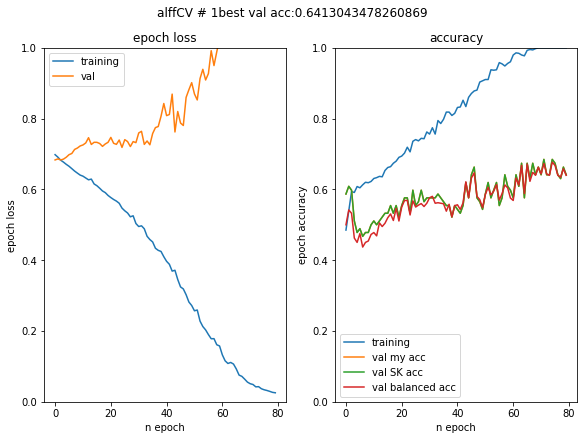

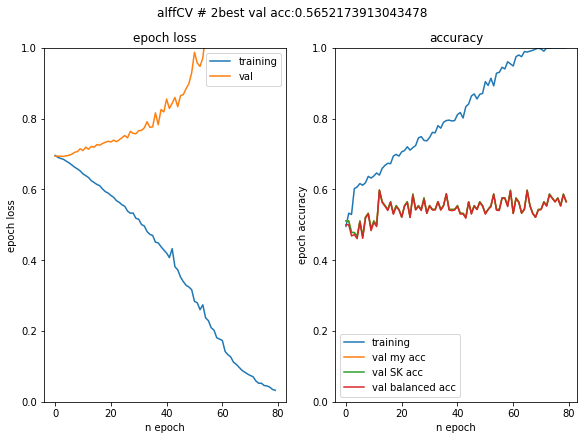

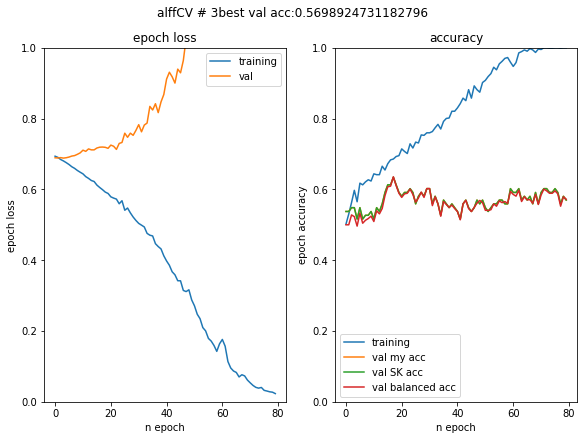

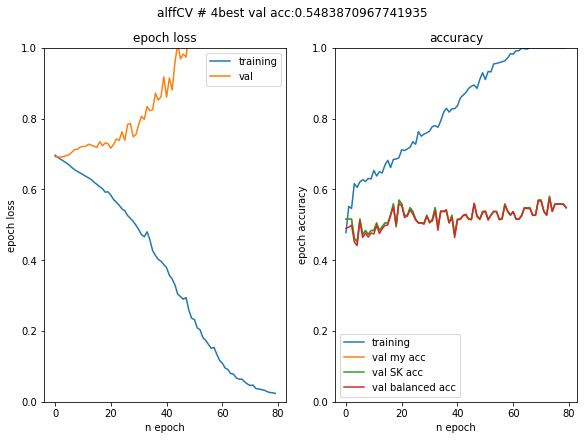

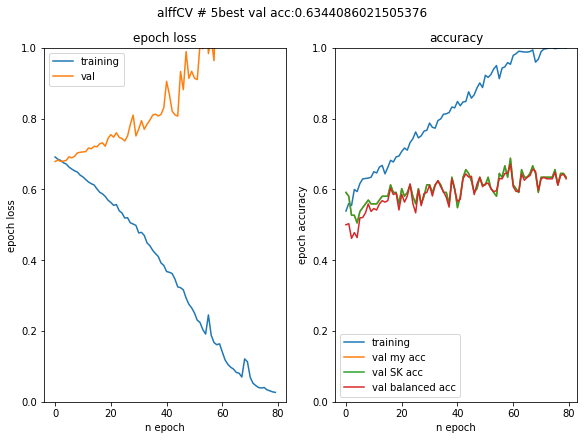

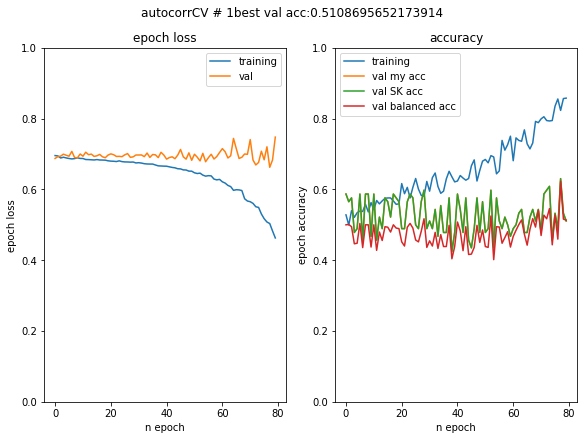

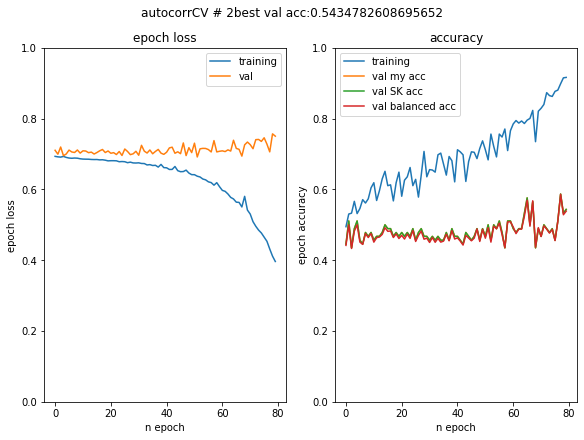

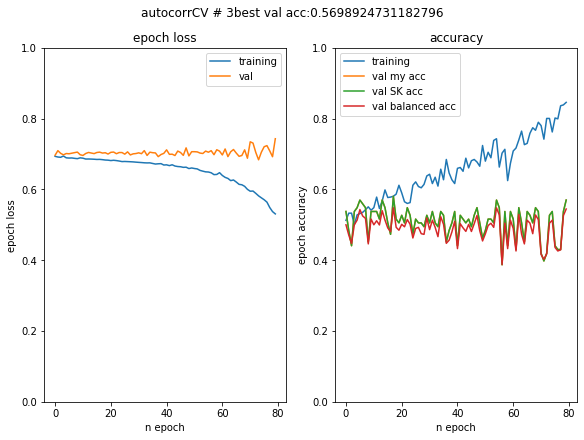

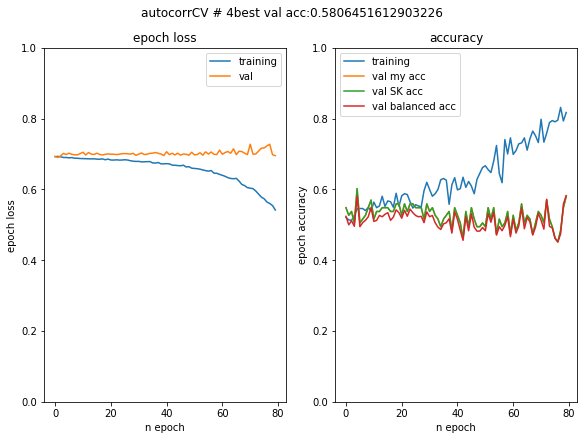

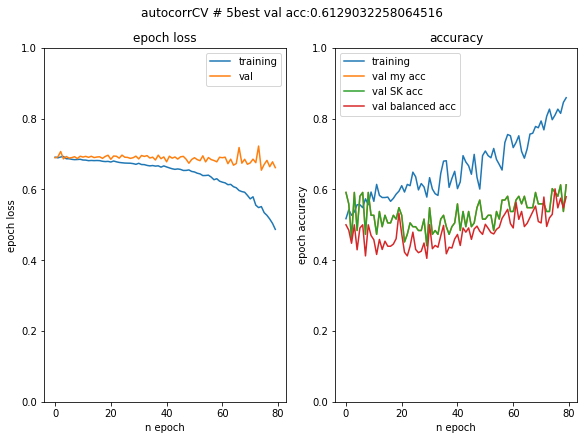

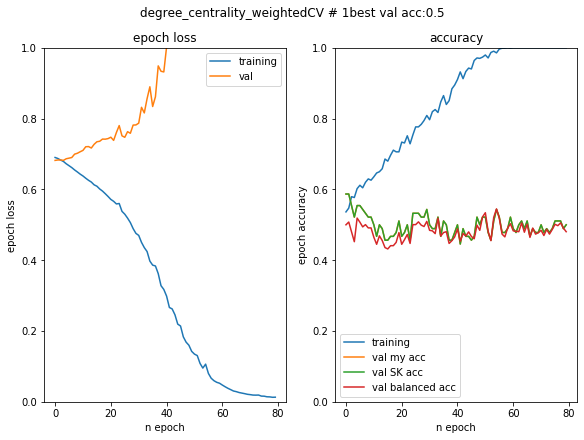

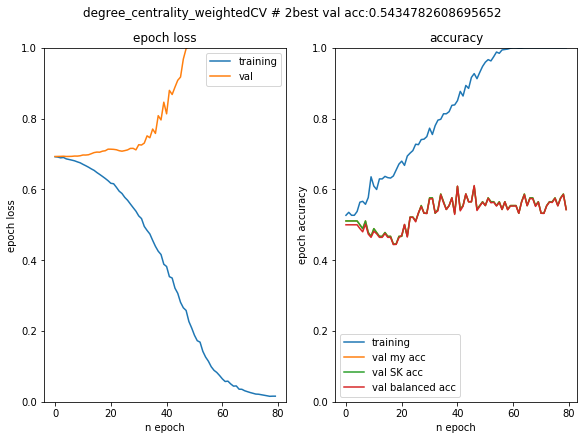

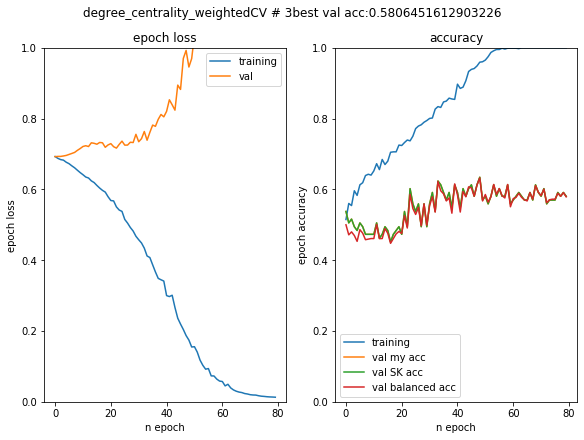

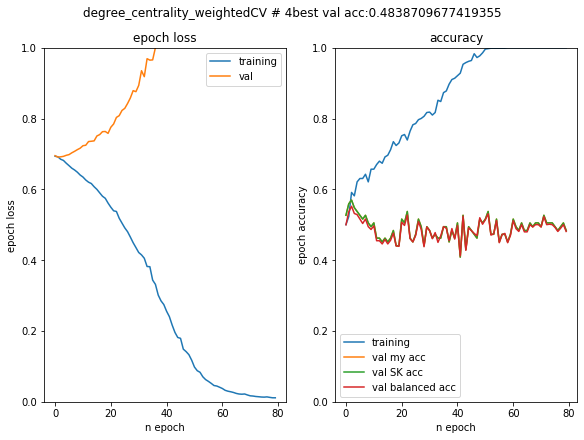

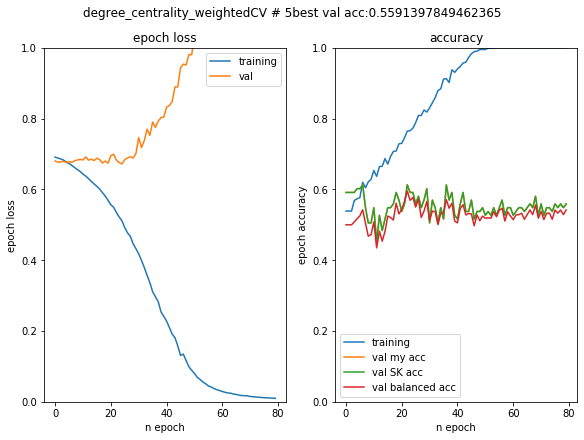

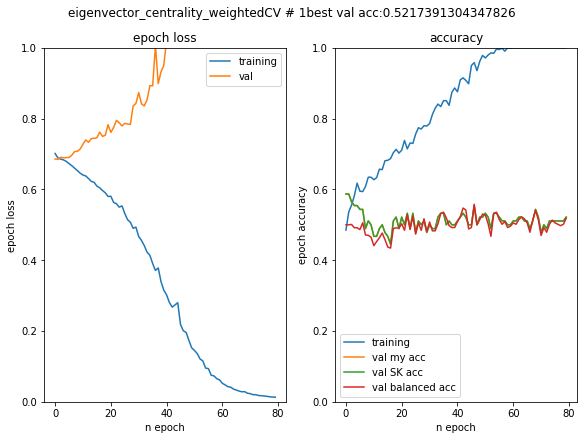

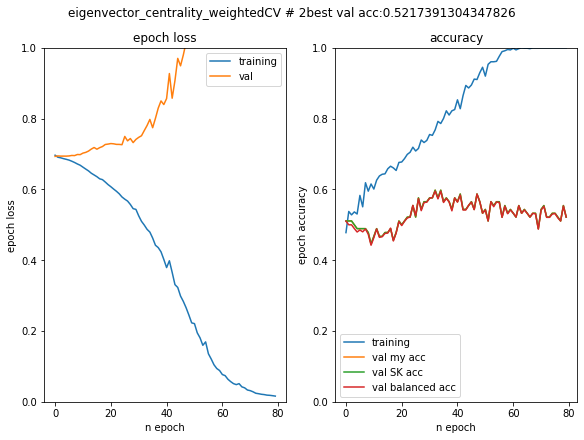

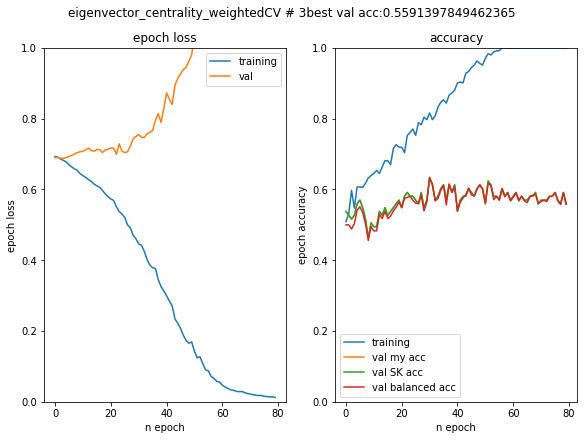

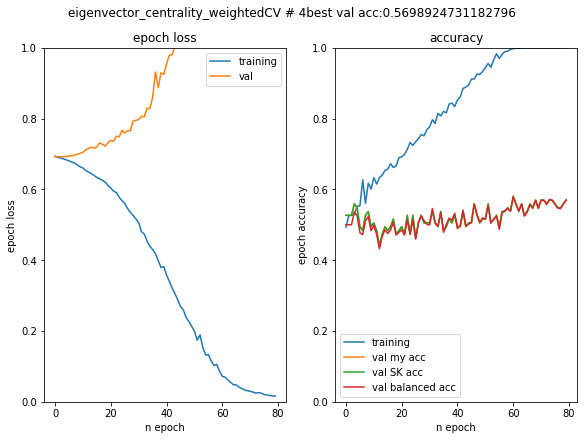

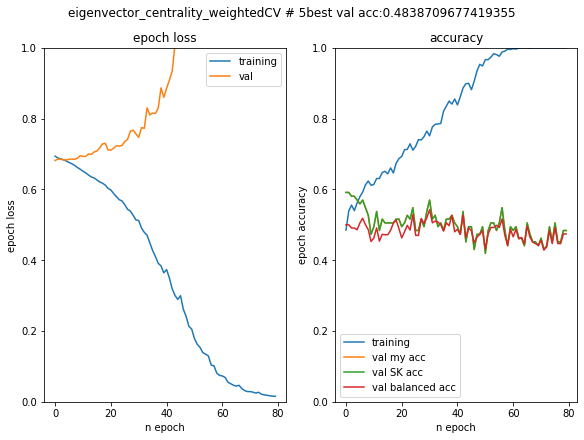

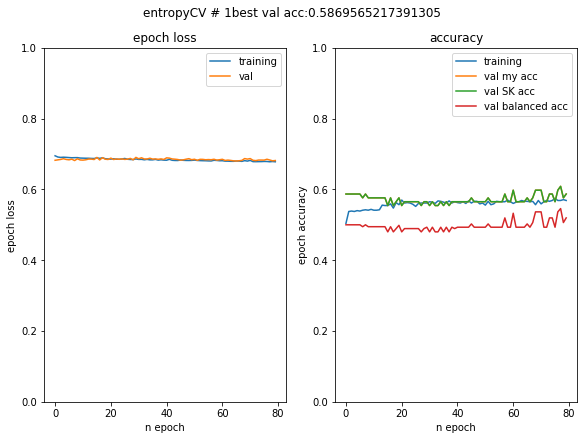

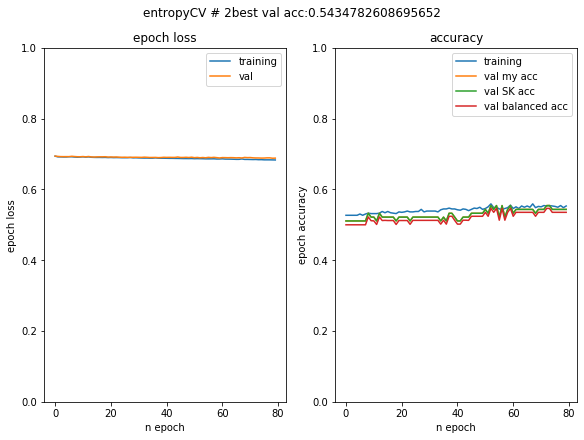

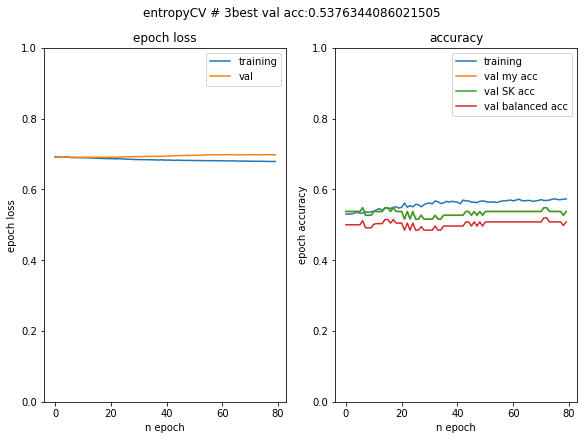

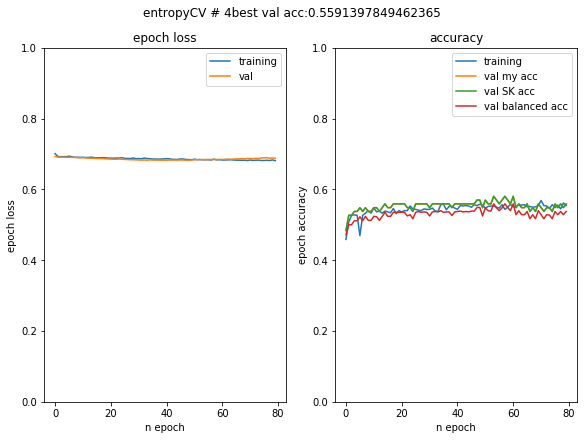

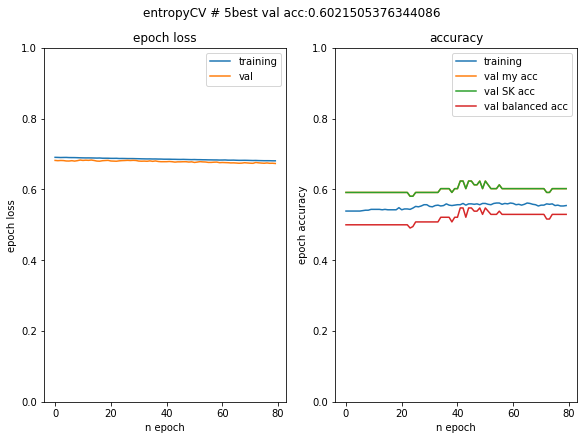

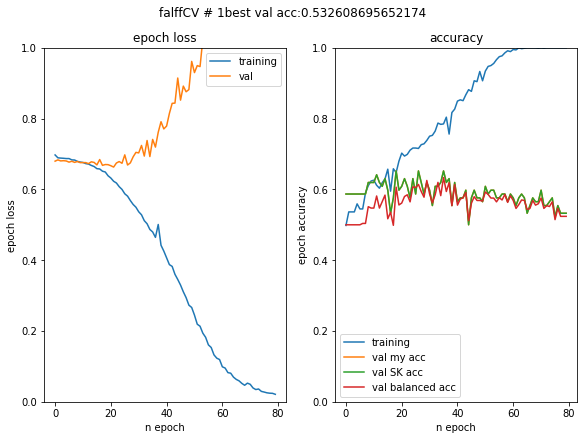

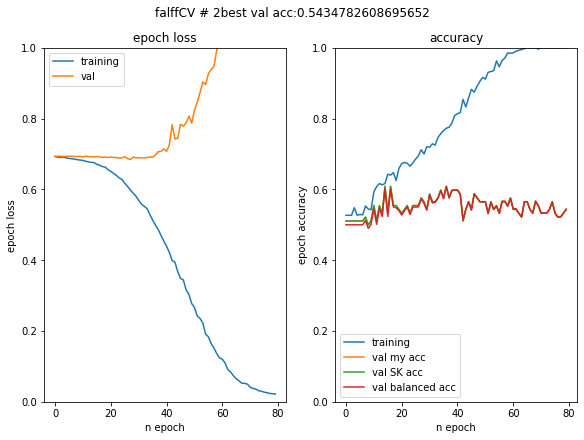

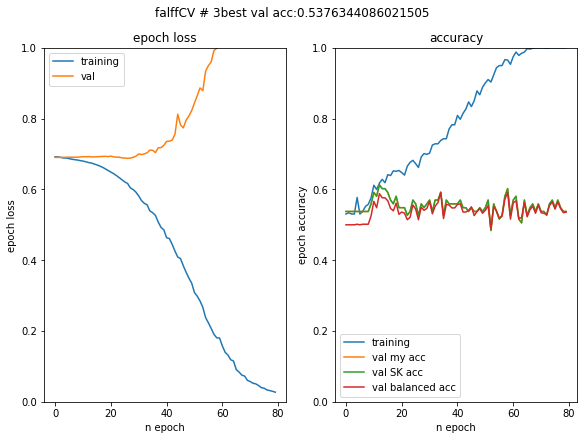

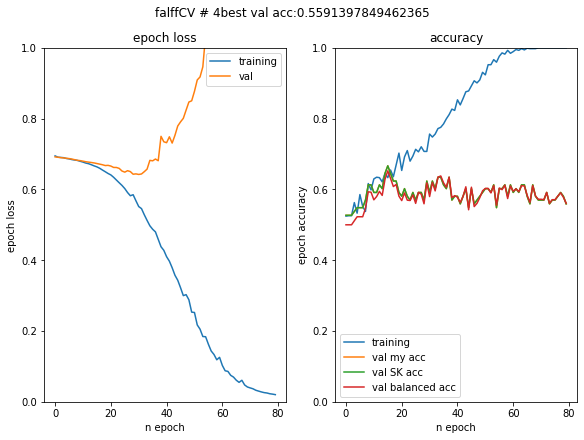

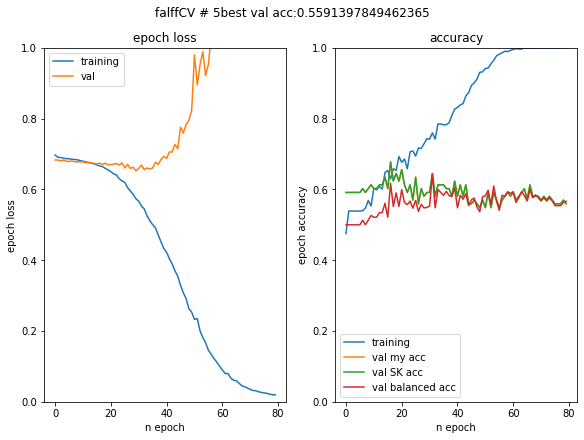

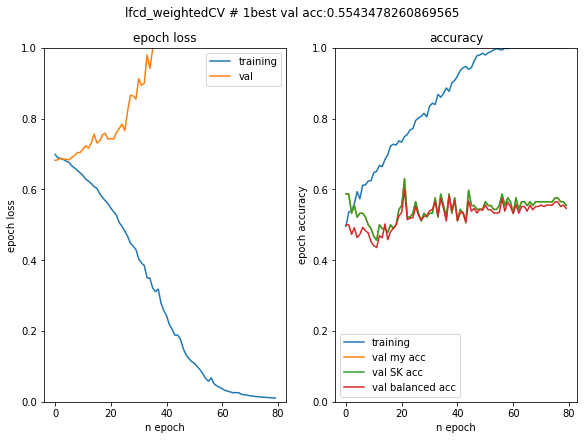

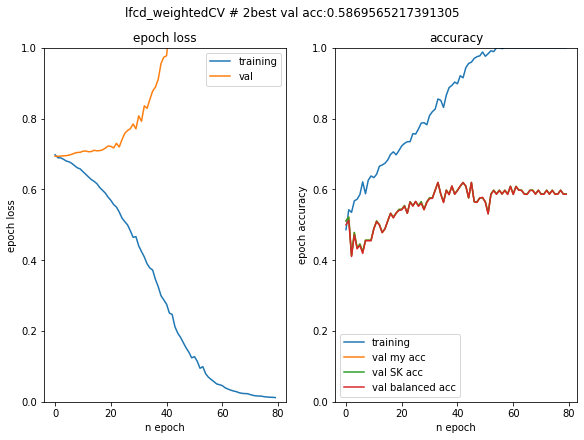

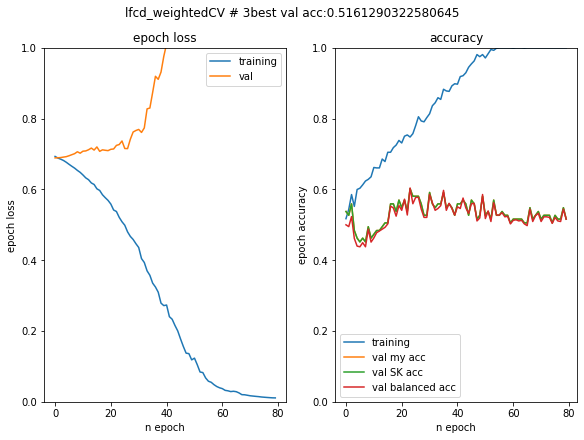

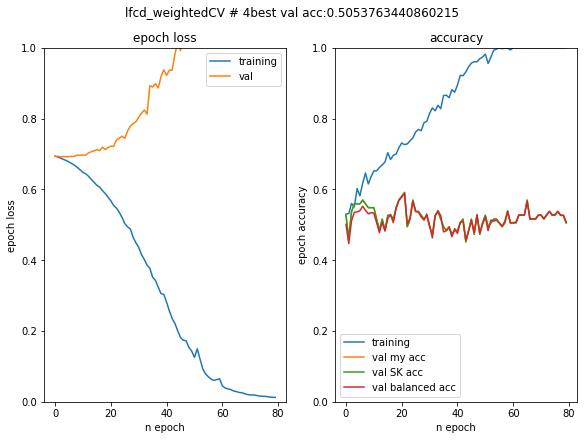

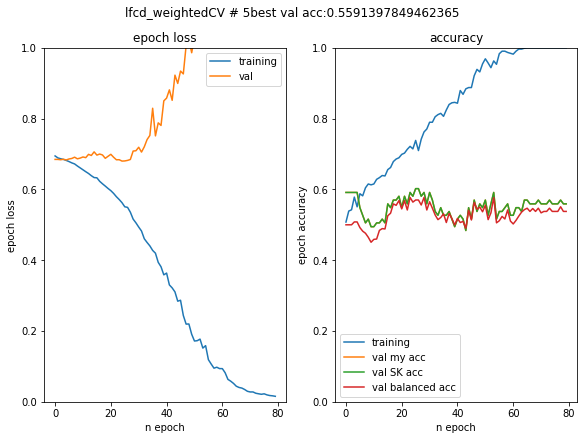

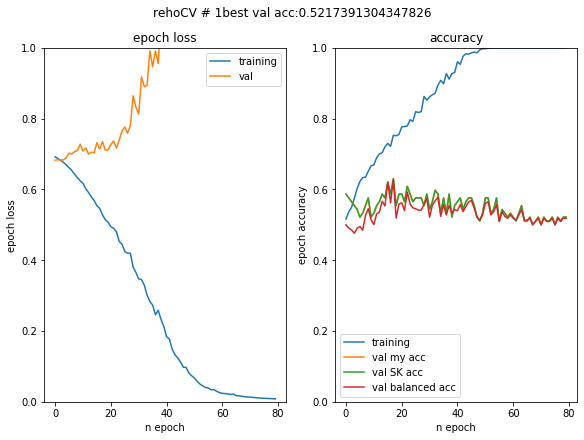

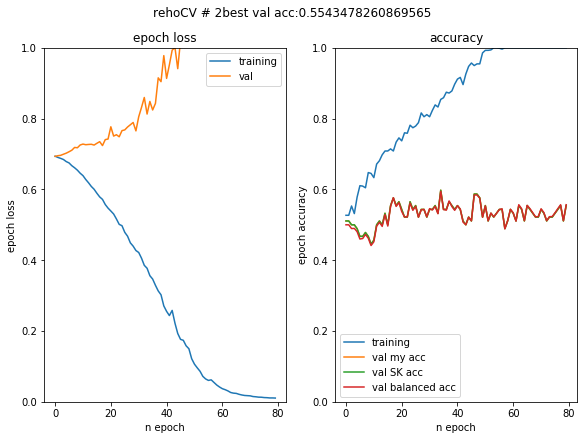

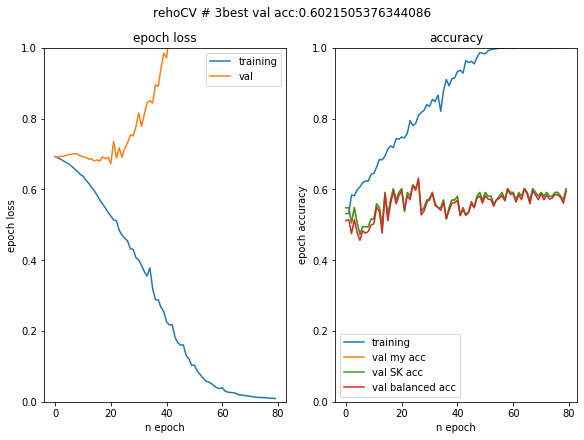

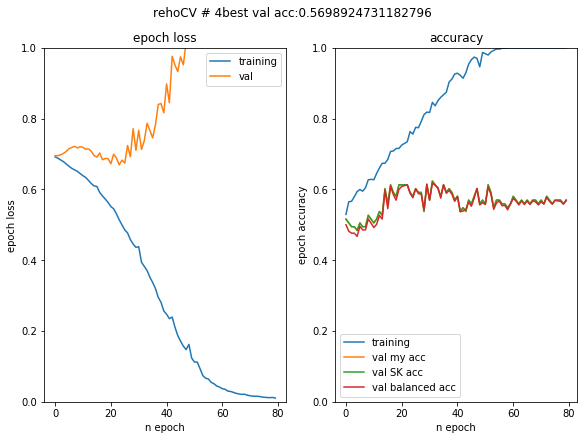

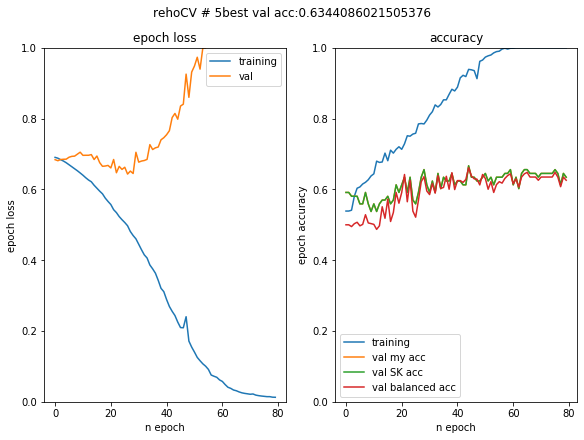

In [15]:

for summaryMeasure in SummaryMeasures_List:
    print(summaryMeasure)
    
    data, label =  select_data(datafile, summaryMeasure, select_ID_i)

    # CROSSVALIDATION LOOP
    txtname= MODEL_STORE_PATH + '/CV_results_' + summaryMeasure + '_.txt'
    ResultsFile = open(txtname,"a")

    CV_bestacc_list=[]
    CV_bestloss_list=[]
    ints = [0, 1, 2, 3, 4]
    for k in ints: 
        print('Start Cross-validation k= {}'.format(k+1))
        train_split_k=train_split[k]
        val_split_k=val_split[k]
        test_split_k=test_split[k]

        #reset the model before new cv
        model=ConvNet()
        model.to(device) 
        # Loss and optimizer
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.SGD(model.parameters(),momentum=0.9, lr = 0.001, weight_decay=1e-3)

        # load data
        trainData = load_data(split='train', 
                              train_split=train_split_k, val_split=val_split_k, test_split=test_split_k,
                              summaryMeasure=summaryMeasure, data = data, label= label)
        valData = load_data(split='val', 
                            train_split=train_split_k, val_split=val_split_k, test_split=test_split_k,
                            summaryMeasure=summaryMeasure, data = data, label= label)
        

        train_loader = DataLoader(dataset=trainData, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(dataset=valData, batch_size=batch_size, shuffle=True)

    # START TRAINING FOR THIS CV
        total_step = len(train_loader)
        total_step_v = len(val_loader)

        # collect loss and acc of each batch
        loss_list = []
        acc_list = []

        loss_v_list=[]
        acc_list_v=[]
        # collect loss and acc of each epoch
        epoch_loss_train = []
        epoch_acc_train = []

        epoch_loss_val  = []
        epoch_myacc_val = []
        epoch_acc_val   = []
        epoch_balacc_val= []
        epoch_F1_Score = []
        best_acc = None

        
        # TRAIN THE MODEL
        for epoch in range(num_epochs):
            total_ep = 0.0
            correct_ep = 0.0
            loss_ep = 0.0


            model.train()

            for i, (images, labels) in enumerate(train_loader):

                if device.type == "cuda":
                    images= images.to(device)     
                    labels= labels.to(device)
                labels=labels.reshape(len(labels),1).type(torch.cuda.FloatTensor)

                # Run the forward pass
                outputs = model(images)
                #print('outputs: {}'.format(outputs))
                loss = criterion(outputs, labels)
                loss_list.append(loss.item())

                # Backprop and perform  optimisation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Track the accuracy
                total = labels.size(0)
                predicted= outputs.data>0.0 #define True if >0.5 and False if <0.5
                correct = (predicted == labels).sum().item()
                acc_list.append(correct / total)
                #print('predic == labab {}'.format(predicted == labels[:,0]))        
                if (i + 1) % 20 == 0:
                    print('{}, Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Train Accuracy: {:.2f}%'
                          .format(summaryMeasure, epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                                  (correct / total) * 100))

                total_ep += total
                correct_ep += correct
                loss_ep += (loss.item()*len(labels))
                #print('summing correct this batch {}'. format(correct_ep))

            if (i + 1)  == total_step: #print only the last one
                    print('{}, CV {}, Epoch [{}/{}], Step [{}/{}], Training Accuracy of the model this epoch is: {} %'
                          .format(summaryMeasure,k+1, epoch + 1, num_epochs, i + 1, total_step, (correct_ep/ total_ep) * 100))

            epoch_acc_train.append((correct_ep/ total_ep))  
            epoch_loss_train.append(loss_ep/ total_ep)


            # Test the model 

            model.eval()

            total_ep = 0.0
            correct_ep = 0.0
            loss_ep = 0.0
            
                    
            # F1 calc
            F1_labels=[]
            F1_pred=[]

            for i, (images, labels) in enumerate(val_loader): #TEST THE MODEL ON THE VALIDATION
            #for i, (images, labels) in enumerate(train_loader): #TEST THE MODEL ON THE TRAINING      

                if device.type == "cuda":
                    images= images.to(device)     
                    labels= labels.to(device)
                labels=labels.reshape(len(labels),1).type(torch.cuda.FloatTensor)

                outputs_v = model(images) # the forward uses the entire batch together
                predicted= outputs_v.data>0.0 #define True if >0.5 and False if <0.5

                # collect true labels and predicted for metrix calc
                if i==0:
                    F1_labels=labels.int().cpu().numpy()
                    F1_pred=predicted.int().cpu().numpy()
                else:
                    F1_labels= np.concatenate((F1_labels, labels.int().cpu().numpy()))
                    F1_pred = np.concatenate((F1_pred, predicted.int().cpu().numpy()))
                
                loss_v = criterion(outputs_v, labels) 
                # Although the loss is one value, it represents the *average* of losses over all examples in the batch
                loss_v_list.append(loss_v.item()) # one item at the time

                total_v = labels.size(0) # get it in case the last batch has different number of sample
                correct_v = (predicted == labels).sum().item() # sum the correct answers for this batch
                acc_list_v.append(correct_v / total_v) # n of correct / n of sample in this batch

                total_ep += total_v # sum all the samples. it must end up being the tot training set
                correct_ep += correct_v # sum together the right answers in entire training set
                loss_ep += (loss_v.item()*len(labels))
            
           # calculate metrices of this epoch
            current_ep_loss=loss_ep/total_ep
            
            current_ep_acc=(correct_ep/total_ep)
            acc = accuracy_score(F1_labels, F1_pred)
            balacc= balanced_accuracy_score(F1_labels, F1_pred)
            
            F1_Score = f1_score(F1_labels, F1_pred, average='weighted')
            tn, fp, fn, tp = confusion_matrix(F1_labels, F1_pred).ravel() 
            
            
            if not best_acc or best_acc < current_ep_acc:
                best_acc = current_ep_acc
                        # SAVE RESULTS IN TABLE (1 for all)      
                s= {'Summary measure': [summaryMeasure], 'Kfold': [k+1], 'epoch': [epoch+1], 
                    'Val Loss': [current_ep_loss],
                    'Val myAcc': [current_ep_acc], 'Val Acc': [acc], 'Val Balanced Acc': [balacc], 
                    'F1':[F1_Score],
                    'True Pos': [tp], 'True Neg': [tn], 'False Pos': [fp], 'False Neg': [fn],
                    'n ADS': [(F1_labels==1).sum()], 'n tot': [len(F1_labels)]}         

                df_best = pd.DataFrame(s)
                
                
                torch.save(model.state_dict(), MODEL_STORE_PATH + '/' + summaryMeasure + '_BEST_model'
                               + '_CV' + str(k+1)
                               + '.pt')  

            # collect matrixes of all the epochs
            epoch_loss_val.append((loss_ep/total_ep))           
            epoch_myacc_val.append((correct_ep/total_ep))
            epoch_acc_val.append(acc)
            epoch_balacc_val.append(balacc)
            
        print('{}, CV_{}, best accuracy = {}'.format(summaryMeasure, k+1, acc))
        
        
        # SAVE RESULTS IN TABLE (1 for all)      
        df=pd.concat([df, df_best])        
 
        # save the table on disk evey cv
        export_csv = df.to_csv (csvname, 
                                index = None, header=True) 
        # PLOT LOSS AND ACCURACY   
        fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize= [8, 6]) #in inch)

        fig.suptitle(summaryMeasure + 'CV # ' + str(k+1) + 'best val acc:' +str(acc) )

        axs[0].plot(epoch_loss_train, label='training')
        axs[0].plot(epoch_loss_val, label='val')
        axs[0].set(ylim=(0.0, 1.0))

        axs[0].set_xlabel('n epoch')
        axs[0].set_ylabel('epoch loss')
        axs[0].set_title('epoch loss')
        axs[0].legend()


        axs[1].plot(epoch_acc_train, label='training')
        axs[1].plot(epoch_myacc_val, label='val my acc') 
        axs[1].plot(epoch_acc_val, label='val SK acc')
        axs[1].plot(epoch_balacc_val, label='val balanced acc')
        axs[1].set_xlabel('n epoch')
        axs[1].set_ylabel('epoch accuracy')
        axs[1].set_title('accuracy')
        axs[1].legend()
        axs[1].set(ylim=(0.0, 1.0))


        fig.title=summaryMeasure
        vis.matplot(fig, env='Model_130120_K-fold5_Stand')

       # ResultsFile.close()

In [ ]:
tn_c, fp_c, fn_c, tp_c = confusion_matrix(F1_labels, F1_pred).ravel()

tn_c

In [ ]:
epoch_acc_val

In [16]:
ResultsFile.close()

In [ ]:
df

In [ ]:
print('training acc last epoch is {}'.format(epoch_acc_train[-1]))
print('validation acc last epoch is {}, best acc is {}, avg acc is {}'.
      format(epoch_acc_val[-1], np.max(epoch_acc_val), np.mean(epoch_acc_val)))

In [ ]:

img, l = trainData[79]
img=img.reshape(45,54,45)
plt.imshow(img[:,:,25])
plt.colorbar()

In [ ]:
hfile.close()